# Functions and imports

In [1]:
# Imports
from util import *
from bqm_operations import *
from embedding_operations import *
import dimod
import pandas as pd
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
from minorminer import find_embedding
import matplotlib as mpl
import scipy

# for the specficiyng the region
# antiferro_color = 'salmon'
# ferro_color = 'palegreen'
# gamma_zero_color = 'slategray'
# background_alpha = 0.5
# gamma_lower_limit, gamma_upper_limit = -0.3, 0.3

# markers = {'optimal':'<', 'zero':'>', 'quantization_error':'o', 'random_error':'v', 'analog_control_error':'v', 0.5:'1', 5:'+'}

# linestyles = {'optimal':(0, (1, 10)),'zero':(0, (5, 10)), 'quantization_error':'dotted', 'random_error':'dashed', 'analog_control_error':'dashdot', 0.5:'dashed', 5:'solid'}

# colors = {'optimal':'purple', 'zero':'darkblue', 'quantization_error':'darkorange', 'random_error':'magenta', 'analog_control_error':'dodgerblue', 0.5:'green', 5:'royalblue'}

antiferro_color = 'lightcoral'
ferro_color = 'lightseagreen'
gamma_zero_color = 'lightgray'
background_alpha = 0.3
gamma_lower_limit, gamma_upper_limit = -0.3, 0.3

markers = {
    'optimal': 'X', 
    'zero': 'P', 
    'quantization_error': 'D', 
    'random_error': '^', 
    'analog_control_error': 's', 
    'no_error': 'X',
    0.5: '1', 
    5: '+',
    'EC_triangle':'X', # Exact cover (EC) gamma sampling
    'EC_direct': '>',  # EC minor embedding for 'direct' problems, no copying
    'EC_optimal':'o',  # EC triangle with optimal gamma
    'EC_zero' : '<'    # EC triangle with gamma zero
}

linestyles = {
    'optimal': (0, (3, 5, 1, 5)), 
    'zero': (0, (3, 10)), 
    'quantization_error': 'dashed', 
    'random_error': 'dotted', 
    'analog_control_error': 'dashdot', 
    'no_error':'dotted',
    0.5: 'solid', 
    5: 'solid',
    'EC_triangle':'dashed', 
    'EC_direct': 'dotted',  
    'EC_optimal':'dashed',  
    'EC_zero' : 'dashdot'    
}

linestyles = {
    'optimal': 'None', 
    'zero': 'None', 
    'quantization_error': 'dashed', 
    'random_error': 'dotted', 
    'analog_control_error': 'dashdot',
    'no_error': 'dotted',
    0.5: 'solid', 
    5: 'solid',
    'EC_triangle':'dashed', 
    'EC_direct': 'dotted',  
    'EC_optimal':'dashed',  
    'EC_zero' : 'dashdot'   
}

colors = {
    'optimal': 'navy', 
    'zero': 'crimson', 
    'quantization_error': 'seagreen', 
    'random_error': 'maroon', 
    'analog_control_error': 'mediumpurple', 
    'no_error' : 'maroon',
    0.5: 'green', 
    5: 'royalblue',
    'EC_triangle':'navy', 
    'EC_direct': 'seagreen',  
    'EC_optimal':'maroon',  
    'EC_zero' : 'mediumpurple'  
}

plt.style.use('/Users/beratyenilen/Desktop/Thesis/CODE/scripts/figurestyle.mplstyle')

latex_text_height_pt = 600
latex_text_width_pt = 434

qem, rem, acem = 'quantization_error', 'random_error', 'analog_control_error'


In [2]:
def get_figsize(text_width_pt, aspect_ratio=None, text_height_pt=None):
    """
    Calculate figure size in inches from text width in points, a given aspect ratio, and optionally text height in points.

    Parameters:
    - text_width_pt: float, The text width in points from LaTeX.
    - aspect_ratio: float, The desired aspect ratio of the figure (width / height).
    - text_height_pt: float, Optional. The text height in points from LaTeX.

    Returns:
    - fig_size: tuple, The figure size in inches as (width, height).
    """
    text_width_in = text_width_pt / 72  # Convert points to inches
    
    # If text_height_pt is provided, use it to calculate the figure height
    if text_height_pt:
        fig_height = text_height_pt / 72  # Convert points to inches
    else:
        # Otherwise, calculate figure height based on the aspect ratio
        fig_height = text_width_in / aspect_ratio
    
    fig_size = (text_width_in, fig_height)
    return fig_size

In [3]:
def to_latex_sci_notation_combined(value1, value2, pr):
    """
    Convert two numbers into a single LaTeX string in scientific notation, combining them with ± and using the same exponent.
    
    Parameters:
    - value1: The first number (e.g., mean).
    - value2: The second number (e.g., standard deviation).
    - pr: Precision (number of decimal places for the base values).
    
    Returns:
    A string representing the combined numbers in LaTeX scientific notation.
    """
    # Determine the common exponent based on the larger of the two values
    larger_value = max(abs(value1), abs(value2))
    if larger_value == 0:
        exponent = 0
    else:
        exponent = int(f"{larger_value:.{pr}e}".split('e')[-1])
    
    # Apply the common exponent to both values
    base1 = value1 / (10 ** exponent)
    base2 = value2 / (10 ** exponent)
    
    # Format the base values with the specified precision
    base1_str = f"{base1:.{pr}f}"
    base2_str = f"{base2:.{pr}f}"
    
    if exponent == 0:
        return f"({base1_str} \\pm {base2_str})"
    else:
        return f"({base1_str} \\pm {base2_str}) \\times 10^{{{exponent}}}"


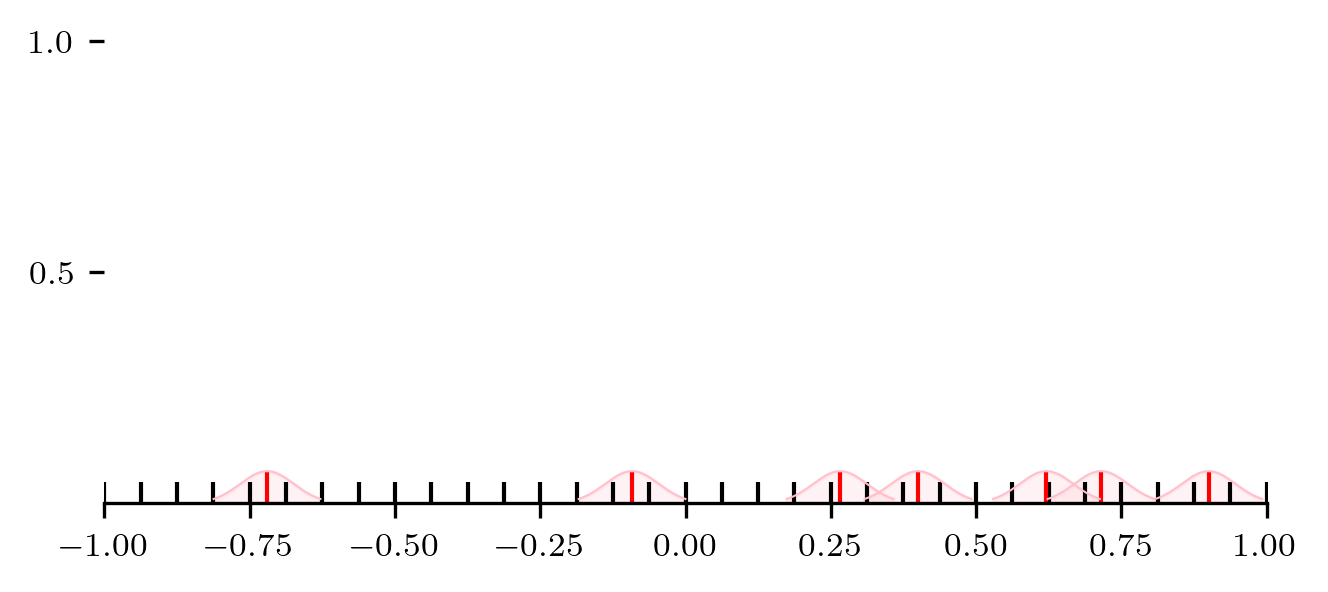

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Re-initialize the values for p and hj_vals
p = 5
p_vals = np.linspace(-1, 1, 2**p + 1)
hj_vals = [-0.092, 0.621, -0.72, 0.266, 0.9, 0.715, 0.40]

# Calculate the standard deviation
std_dev = 1 / (2**p + 1) + 1 / (2 **(p + 1))

# Bell curve parameters
bell_height = 0.008  # The height of the bell curve
bell_color = 'pink'  # The color of the bell curve

# Redefine the plotting function to draw and fill bell curves up to two standard deviations only

# Set up the figure and axis again
figure, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=300)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5, 1])

# Plot the base points again
ax.plot(p_vals, [0]*len(p_vals), marker='|', linestyle='None', color='black', markersize=10)
ax.plot(hj_vals, [0]*len(hj_vals), marker='|', linestyle='None', color='red', markersize=15)

# Plot and fill the bell curves within two standard deviations around each hj_val
for val in hj_vals:
    # Define the range for two standard deviations
    x_dev_range = np.linspace(val - 2 * std_dev, val + 2 * std_dev, 1000)
    
    # Calculate the bell curve values within the two standard deviations
    bell_curve = norm.pdf(x_dev_range, val, std_dev) * bell_height
    
    # Plot the curve
    ax.plot(x_dev_range, bell_curve, color=bell_color, linewidth=0.5)
    
    # Fill under the curve within two standard deviations
    ax.fill_between(x_dev_range, 0, bell_curve, color=bell_color, alpha=0.2)

plt.show()



In [ ]:
p3 = np.linspace(-1,1, 2**3+1)
p4 = np.linspace(-1,1, 2**4+1)
p5 = np.linspace(-1,1, 2**5+1)

p = p5
figure, ax = plt.subplots(1,1, figsize=(5,2), dpi=300)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5,1])

ax.plot(p, [0]*len(p), marker='|', linestyle='None', color='black', markersize=10)

hj_vals = [-0.092, 0.621, -0.72, 0.266, 0.9, 0.715, 0.40]

ax.plot(hj_vals, [0]*len(hj_vals), marker='|', linestyle='None', color='red', markersize=15)

# Theory

This part is for generating the Chimera and Pegasus graph illustrations


## Chimera graph

In [ ]:
# first let's draw the Chimera bulk by highlighting the u,k coordinates
chimera_bulk = dnx.chimera_graph(m=1)
chimera_coordinates = dnx.chimera_coordinates(1)
# Relabel nodes with u,k
nx.relabel_nodes(chimera_bulk, mapping=lambda x: chimera_coordinates.linear_to_chimera(x)[2:], copy=False)
figure = plt.figure(figsize=(5,5), dpi=300)
dnx.draw_chimera(chimera_bulk, with_labels=True, node_size=3000, font_size=20)
#figure.savefig("./figures_to_thesis/chimera_bulk.pdf")

In [ ]:
# This bit is for plotting the whole Chimera graph
m = 4
chimera_bulk = dnx.chimera_graph(m=m)
chimera_coords = dnx.chimera_coordinates(m)

qubit_labels = {
    chimera_coords.chimera_to_linear((0, 0, 1, 0)): 'x,y=0'
}

qubit_labels.update({
    chimera_coords.chimera_to_linear((0, x, 1, 0)): f'x={x}' for x in range(1,m)
})
qubit_labels.update({
    chimera_coords.chimera_to_linear((y, 0, 1, 0)): f'y={y}' for y in range(1,m)
})

# Relabel nodes with u,k

fig,ax = plt.subplots(figsize=(10,10), dpi=300)
dnx.draw_chimera(dnx.chimera_graph(m), ax=ax, node_size=500,  edge_color='gray')
plt.margins(x=-0.02, y=-0.02)
#dnx.draw_chimera(dnx.chimera_graph(m, node_list=qubit_labels), labels=qubit_labels, ax=ax, node_size=500, edge_color='gray', font_size=20)
#fig.savefig("./figures_to_thesis/chimera_m-4.pdf")

## Pegasus graph

In [ ]:
# for constructing a Pegasus bulk
m = 2
pegasus_bulk = dnx.pegasus_graph(m=m, nice_coordinates=True)
pegasus_coords = dnx.pegasus_coordinates(m)

figsize = get_figsize(text_width_pt=0.4*latex_text_width_pt, text_height_pt=0.3*latex_text_height_pt)
# Relabel nodes with u,k
fig,ax = plt.subplots(figsize=figsize, dpi=300)

dnx.draw_pegasus(pegasus_bulk, ax=ax, node_size=50,  edge_color='gray', width=0.5, node_color='red')
plt.margins(x=-0.002, y=-0.002)
#dnx.draw_chimera(dnx.chimera_graph(m, node_list=qubit_labels), labels=qubit_labels, ax=ax, node_size=500, edge_color='gray', font_size=20)
#fig.savefig("./figures_to_thesis/pegasus_bulk.pdf")

In [ ]:
# This bit is for plotting the whole Pegasus m=2 graph
m = 4
pegasus_coords = dnx.pegasus_coordinates(m)

qubit_labels = {
    pegasus_coords.nice_to_linear((0, 0, 0, 0, 0)): 'x,y=0\nt=0',
    pegasus_coords.nice_to_linear((1, 0, 0, 0, 0)): 't=1',
    pegasus_coords.nice_to_linear((2, 0, 0, 0, 0)): 't=2',
}
qubit_labels.update({
    pegasus_coords.nice_to_linear((0, 0, x, 0, 0)): f'x={x}' for x in range(1,m-1)
})
qubit_labels.update({
    pegasus_coords.nice_to_linear((0, y, 0, 0, 0)): f'y={y}' for y in range(1,m-1)
})

figsize = get_figsize(text_width_pt=latex_text_width_pt, text_height_pt=0.8*latex_text_height_pt)

fig,ax = plt.subplots(1, 1, figsize=figsize, dpi=300)

dnx.draw_pegasus(dnx.pegasus_graph(m), ax=ax, crosses=True, node_size=60, node_color='red', edge_color='gray', width=0.5)
dnx.draw_pegasus(dnx.pegasus_graph(m, node_list=qubit_labels), labels=qubit_labels, ax=ax, crosses=True, node_size=250, font_size=10, node_color='yellow', edge_color='gray')
#plt.margins(x=-0.5, y=-0.)
#fig.savefig("./figures_to_thesis/pegasus_m-4.pdf")

In [ ]:
print(len(dnx.pegasus_graph(4).nodes))

In [ ]:
# Generating a problem instance with its minor embedding 
N = 6
M = 16
complete_graph = nx.complete_graph(N)
pegasus_graph = dnx.pegasus_graph(M)

#emb = find_embedding(complete_graph, pegasus_graph)
# this is the embedding I used in the thesis
emb = {0: [4879, 880], 1: [4849], 2: [4864, 955], 3: [910], 4: [4834], 5: [925]}
emb_graph = remove_irrelevant_nodes(pegasus_graph, emb, graph_type='pegasus')

only_emb_graph = remove_irrelevant_nodes(pegasus_graph, emb, only_emb_qubits=True)


In [ ]:
figure, ax = plt.subplots(1,1, figsize=(5,5), dpi=500)
nx.draw(complete_graph, node_size=500, with_labels=True, font_size=20)
#figure.savefig("./figures_to_thesis/problem_graph.pdf")

In [ ]:

figure, ax = plt.subplots(1,1, figsize=(10,10), dpi=500)
dnx.draw_pegasus(emb_graph, ax=ax, node_color='gray', edge_color='gray', width=0.5, alpha=0.7, node_size=500, crosses=True)
dnx.draw_pegasus_embedding(only_emb_graph, emb, show_labels=True, width=1.5, font_size=20, node_size=800, ax=ax, crosses=True)
#figure.savefig("./figures_to_thesis/emb_graph.pdf")

In [ ]:
# Let's generate an antiferromagnetic chain problem with length 50
L = 50
bqm = dimod.BinaryQuadraticModel(vartype=dimod.SPIN)
# add the variables
for i in range(L):
  bqm.add_variable(i)

for i in range(L-1):
  bqm.add_quadratic(i,i+1, -1)

# find an embedding for it
# choose the sampler
sampler = DWaveSampler(solver_id='Advantage_system5.4')
sampler_graph = sampler.to_networkx_graph()
bqm_graph = dimod.to_networkx_graph(bqm)
# this is the embedding we used
emb = {0: [1112, 3351, 1127], 1: [1113], 2: [1114], 3: [3681], 4: [1233], 5: [1231, 3306, 1232], 6: [1141], 7: [3365], 8: [3364], 9: [3379], 10: [947, 3320], 11: [3319], 12: [781], 13: [3228], 14: [826], 15: [856, 3289], 16: [3213], 17: [3214], 18: [901], 19: [3184], 20: [706, 3183], 21: [707], 22: [3393], 23: [797], 24: [796], 25: [3198, 3199, 795], 26: [3197], 27: [526], 28: [3167], 29: [3168], 30: [3258, 736], 31: [3243], 32: [661], 33: [3273], 34: [676], 35: [3002, 675], 36: [525], 37: [3137], 38: [495], 39: [2987], 40: [585, 2988], 41: [705], 42: [3123], 43: [3138], 44: [600], 45: [3032, 570], 46: [630], 47: [631], 48: [632], 49: [3542]}

In [ ]:
average_chain_length = np.mean([len(chain) for chain in emb.values()])
max_chain_length = max([len(chain) for chain in emb.values()])
num_qubits_in_embedding = sum([len(chain) for chain in emb.values()])

print(f"Average chain length = {average_chain_length}")
print(f"Maximum chain length = {max_chain_length}")
print(f"Total number of qubits in the embedding = {num_qubits_in_embedding}")

In [ ]:
# sample results
embedded_sampler = FixedEmbeddingComposite(sampler, emb)
max_strength = get_max_strength(bqm)
rcs_range = np.linspace(0.5, 2, 20)
all_results = []
num_reads = 1000
AT = 5
for rcs in rcs_range:
  results = embedded_sampler.sample(bqm, num_reads=num_reads, annealing_time=AT, chain_strength=max_strength*rcs)
  all_results.append(results)

In [ ]:
# calculate the success rate
min_energy = -L + 1
success_rates = []
for result in all_results:
  sr = 0
  for energy, num_occur in result.data(fields=['energy', 'num_occurrences']):
    if energy == min_energy:
      sr += num_occur / num_reads
  success_rates.append(sr)

print(f"RCS range is")
print(list(rcs_range))
print("Success rates are")
print(success_rates)
figure, ax = plt.subplots(1,1, dpi=500)

ax.plot(rcs_range, success_rates, marker='v', linestyle='--')
ax.set_xlabel("Relative chain strength", fontsize=15)
ax.set_ylabel("Probability of ground state", fontsize=15)
ax.grid()
figure.savefig("./figures_to_thesis/rcs_scan_example.pdf")

## Pause Quench Annealing schedules 

In [ ]:
# plotting example Schedules
figure, axs = plt.subplots(1,3, dpi=500, figsize=(18,5), sharey=False)
# make the axes pretty
for i in range(3):
  axs[i].grid()
  axs[i].set_xlabel("time ($\mu s$)", fontsize=20)
  axs[i].set_ylabel("s", fontsize=20)

# Pausing data points
s_vals = list(np.linspace(0, 0.5, 100)) + [0.5]*200 + list(np.linspace(0.5, 1.0, 100))
t_vals = np.linspace(0, 20, len(s_vals))
axs[0].plot(t_vals, s_vals, linewidth=2)
axs[0].set_title("Pausing", fontsize=20)

# Quenching
s_vals = list(np.linspace(0, 0.7, 200)) + list(np.linspace(0.7, 1.0, 6)) 
t_vals = np.linspace(0, 20, len(s_vals))
axs[1].plot(t_vals, s_vals, linewidth=2)
axs[1].set_title("Quenching", fontsize=20)

# reverse annealing
rev_point = 0.4
s_vals = list(np.linspace(1.0, rev_point, 50)) + [rev_point]*100 + list(np.linspace(rev_point, 1.0, 100))
t_vals = np.linspace(0, 20, len(s_vals))
axs[2].set_ylim(0, 1.05)
axs[2].plot(t_vals, s_vals, linewidth=2)
axs[2].set_title("Reverse annealing", fontsize=20)

figure.tight_layout()
figure.savefig("./figures_to_thesis/example_annealing_schedules.pdf")

## A/B Annealing schedule

In [ ]:
# plotting example Schedules
figsize = get_figsize(text_width_pt=0.5*latex_text_width_pt, text_height_pt=0.3*latex_text_height_pt)

figure, ax = plt.subplots(1,1, dpi=500, figsize=figsize, sharey=False)

# Load the excel file
file_path = '/Users/beratyenilen/Desktop/Thesis/CODE/scripts/09-1265A-D_Advantage_system5_4_annealing_schedule.xlsx'

# Since we need the second sheet, we'll read it into a pandas dataframe
# We are assuming that the data is in the first three columns of the second sheet
# If it is not the case, this code needs to be adjusted to the correct columns
df = pd.read_excel(file_path, sheet_name=1, usecols=[0, 1, 2])

# Extract the s, A(s), B(s) columns into individual lists
s = df.iloc[:, 0].tolist()
As = df.iloc[:, 1].tolist()
Bs = df.iloc[:, 2].tolist()


ax.plot(s, As, label="A(s)", color='salmon')
ax.plot(s, Bs, label="B(s)", color='navy')
ax.legend()

# make the axes pretty
ax.grid()
ax.set_xlabel(f"s")
ax.set_ylabel(f"Energy (GHz)")
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)

In [ ]:
figure.savefig("figures_to_thesis/AsBs_example.pdf", format='pdf', dpi=300)

## Exact cover example


In [ ]:

def draw_bqm_w_color(bqm, ax, with_labels=True, font_color='white', node_size=500, edge_width=1, font_size=12):    
    # Create a networkx graph from the BinaryQuadraticModel
    G = nx.Graph()
    linear_terms = list(bqm.linear.values())
    quadratic_terms = list(bqm.quadratic.values())
    
    # Combine, sort, and make unique values for colormap
    all_values = sorted(set(linear_terms + quadratic_terms))
    cmap = mpl.colormaps['Dark2']
    n_values = len(all_values)
    val2color = {val: cmap.colors[i % len(cmap.colors)] for i, val in enumerate(all_values)}

    # Add nodes with attributes for coloring
    for node, value in bqm.linear.items():
        G.add_node(node, color=val2color[value])
    
    # Add edges with attributes for coloring
    for (u, v), value in bqm.quadratic.items():
        G.add_edge(u, v, color=val2color[value])
    
    # Extract color values for nodes and edges
    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    edge_colors = [data['color'] for _, _, data in G.edges(data=True)]
    
    # Draw the graph
    nx.draw_circular(G, ax=ax, with_labels=with_labels, font_color=font_color, node_size=node_size, 
                     node_color=node_colors, edge_color=edge_colors, width=edge_width, font_size=font_size)
    
    # Create a custom colorbar with evenly spaced colors
    cmap = mpl.colors.ListedColormap([val2color[val] for val in all_values])
    bounds = np.linspace(0, n_values, n_values + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(n_values) + 0.5)
    cbar.set_ticklabels([str(val) for val in all_values])


In [ ]:
example_file_path = '/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/EC_example.txt'
bqm, gs, gs_energy = create_bqm_from_qubo(example_file_path)

In [ ]:
iss = bqm.to_ising()
h,j = iss[0], iss[1]

bqm_ising = dimod.BinaryQuadraticModel.from_ising(h=h, J=j)

In [ ]:

figsize = get_figsize(0.8*latex_text_width_pt, text_height_pt=0.3*latex_text_height_pt )
figure, ax = plt.subplots(1,1, figsize=figsize)

cmap = draw_bqm_w_color(bqm, ax, edge_width=2, font_size=14)
#plt.subplots_adjust(left=0, right=0.98, bottom=0.1, top=9.9, wspace=0.05, hspace=0.06)

In [ ]:
figure.savefig("./figures_to_thesis/EC_example.pdf", format='pdf', dpi=300)

## Broken Qubits of Advantage_system5.4

In [ ]:

def draw_broken_qubits(pegasus_graph, broken_qubits, broken_couplers, ax, broken_node_color='red', node_color='lightblue', node_size=100, edge_width=1):
    """
    Draws a Pegasus graph highlighting broken qubits and edges associated with them.

    Parameters:
    - pegasus_graph: A Pegasus graph object from dwave_networkx.
    - broken_qubits: A list of nodes (qubits) considered broken.
    - broken_node_color: Color for the broken nodes. Default is 'red'.
    - node_color: Color for the rest of the nodes. Default is 'lightblue'.
    """
    broken_edge_width = 5*edge_width
    broken_node_size = 1.5*node_size
     # Initialize an edge color map, marking edges that connect to broken qubits
    edge_color_map = []
    edge_width_map = []
    counter = 0
    for edge in pegasus_graph.edges():
        if edge in broken_couplers:
            edge_color_map.append(broken_node_color)
            counter += 1
            edge_width_map.append(broken_edge_width)
        else:
            edge_color_map.append('gray')  # Default edge color (black)
            edge_width_map.append(edge_width)
    print(counter)
     # Draw the entire graph with default node and edge colors
    dnx.draw_pegasus(pegasus_graph, ax=ax, with_labels=False, node_color=node_color, 
                     edge_color=edge_color_map, node_size=node_size, width=edge_width_map, crosses=True)

    # Extract subgraph of broken qubits
    broken_subgraph = pegasus_graph.subgraph(broken_qubits)
    
    # Draw only the broken qubits and edges connecting them, on top of the existing graph
    # Note: Adjust node_size and width if necessary to make broken qubits more visible
    dnx.draw_pegasus(broken_subgraph, ax=ax, with_labels=False, node_color=broken_node_color, 
                     edge_color=broken_node_color, node_size=broken_node_size, width=broken_edge_width, crosses=True)



In [ ]:
sampler = DWaveSampler(solver='Advantage_system5.4', region='eu-central-1')
sampler_graph = sampler.to_networkx_graph()


pegasus_graph = dnx.pegasus_graph(16)

broken_qubits = set(pegasus_graph.nodes).difference(set(sampler_graph.nodes))
broken_couplers = [edge for edge in pegasus_graph.edges if edge not in sampler_graph.edges]

In [ ]:
figsize = get_figsize(text_width_pt=latex_text_width_pt, text_height_pt=latex_text_height_pt)
figure, ax = plt.subplots(1,1, figsize=figsize)

figure.subplots_adjust(left=0, right=1, top=1, bottom=0)
draw_broken_qubits(pegasus_graph, broken_qubits, broken_couplers, ax=ax, edge_width=0.1, node_size=10)

In [ ]:
#figure.savefig("./figures_to_thesis/ADV54_broken_qubits.pdf", format='pdf', dpi=300)

## Printing embedding info for Exact cover problems

In [70]:
def get_emb_info(emb:dict):
  '''
    Given an embedding prints the average chain length, maximum chain length and the number of qubits used.
  '''
  chain_lengths = [len(chain) for chain in emb.values()]
  total_num_qubits = sum(chain_lengths)
  average_chain_length = np.mean(chain_lengths)
  stdev_chain_length = np.std(chain_lengths)
  
  return total_num_qubits, average_chain_length, stdev_chain_length
  

In [75]:
NTSs, NSSs = [6,12,18,24,30], [2,2,3,4,5]
emb_infos = {'direct': {'total': {6:0, 12:0, 18:0, 24:0, 30:0},
                       'average': {6:0, 12:0, 18:0, 24:0, 30:0}, 
                       'stdev':{6:0, 12:0, 18:0, 24:0, 30:0} }, 
            'triangle': {'total': {6:0, 12:0, 18:0, 24:0, 30:0},
                       'average': {6:0, 12:0, 18:0, 24:0, 30:0}, 
                       'stdev':{6:0, 12:0, 18:0, 24:0, 30:0} }}

all_seeds = {6:range(1,10), 12:range(1,50), 18:range(1,50), 24:range(1,50), 30:range(1,50)}

for NTS, NSS, seeds in zip(NTSs, NSSs, all_seeds.values()):
  len_seeds = len(seeds)
  for seed in seeds:

    fname = f"/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/Exact_Cover/embeddings/Advantage_system5.4/NTS|{NTS}_NSS|{NSS}_seed|{seed}_direct-tiled.json"
    with open(fname, 'r') as f:
      direct_emb_tiled = json.load(f)

    fname = f"/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/Exact_Cover/embeddings/Advantage_system5.4/NTS|{NTS}_NSS|{NSS}_seed|{seed}_triangle.json"
    with open(fname, 'r') as f:
      triangle_emb = json.load(f)


    dir_tiled_total, dir_tiled_av, dir_tiled_std = get_emb_info(direct_emb_tiled)
    tr_total, tr_av, tr_std = get_emb_info(triangle_emb)
    
    emb_infos['direct']['total'][NTS] += dir_tiled_total / len_seeds
    emb_infos['direct']['average'][NTS] += dir_tiled_av / len_seeds
    emb_infos['direct']['stdev'][NTS] += dir_tiled_std / len_seeds

    emb_infos['triangle']['total'][NTS] += tr_total / len_seeds
    emb_infos['triangle']['average'][NTS] += tr_av / len_seeds
    emb_infos['triangle']['stdev'][NTS] += tr_std / len_seeds

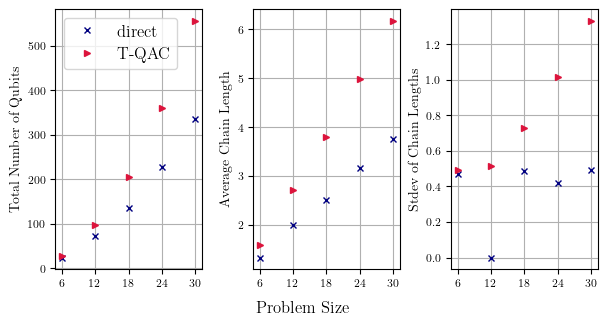

In [108]:
figsize = get_figsize(latex_text_width_pt, text_height_pt=0.4*latex_text_height_pt)

figure, axs = plt.subplots(1,3, figsize=figsize, sharex=True)

axs[0].plot(NTSs, emb_infos['direct']['total'].values(), marker='x', label='direct', color='navy', linestyle='None')
axs[0].plot(NTSs, emb_infos['triangle']['total'].values(), marker='>', label='T-QAC', color='crimson', linestyle='None')
axs[0].grid()
axs[0].set_ylabel('Total Number of Qubits')
axs[0].legend(loc='upper left')
axs[0].set_xticks(NTSs)

axs[1].plot(NTSs, emb_infos['direct']['average'].values(), marker='x', color='navy', linestyle='None')
axs[1].plot(NTSs, emb_infos['triangle']['average'].values(), marker='>',  color='crimson', linestyle='None')
axs[1].grid()
axs[1].set_ylabel('Average Chain Length')

axs[2].plot(NTSs, emb_infos['direct']['stdev'].values(), marker='x', color='navy', linestyle='None')
axs[2].plot(NTSs, emb_infos['triangle']['stdev'].values(), marker='>',  color='crimson', linestyle='None')
axs[2].grid()
axs[2].set_ylabel('Stdev of Chain Lengths')

figure.supxlabel("Problem Size")

plt.subplots_adjust(left=0.09, right=0.99, bottom=0.15, top=0.93, wspace=0.35, hspace=0.5)

In [109]:
#figure.savefig(f"./figures_to_thesis/EC_embedding_comparison.pdf", format='pdf', dpi=300)

# Results

## ResultsManager

In [4]:
class ResultsManager:
  def __init__(self, sampler_ids: list[str], Ls: list[int], error_models: list[str], precisions: list[int], seeds: dict[str, list[int]], problem_types: list[str], ATs, main_directory:str, gamma:float=None, tiled:bool=False):
    '''
      Laods all the results with the given set of parameters.
    '''
    self.sampler_ids = sampler_ids
    self.Ls = Ls
    self.error_models = error_models
    self.precisions = precisions
    self.seeds = seeds
    self.problem_types = problem_types
    self.ATs = ATs
    self.main_directory = main_directory
    self.results = {}
    self.num_copies = 3
    if tiled == True:
      raise Exception("This is not implemented yet!!")
    self.gamma_ranges = {}
    if gamma == None:
      self.load_all_results()
      self.sort_gamma_ranges()
    else:
      gamma = float(gamma)
      self.load_all_results_w_gamma(gamma)

      
  
  def sort_gamma_ranges(self):
    '''
      self.gamma_ranges[error_model][precision] stores the gamma range for the given problem.
      This function simply sorts the gamma values.
    '''
    for error_model, p_dict in self.gamma_ranges.items():
      for precision in p_dict.keys():
        self.gamma_ranges[error_model][precision].sort()

  def load_all_results_w_gamma(self, gamma):
    '''
      Loads all results with gamma self.gamma_ranges to self.results.
    '''
    for sampler_id in self.sampler_ids:
      for L in self.Ls:
        for error_model in self.error_models:
          self.gamma_ranges[error_model] = {}
          for precision in self.precisions:
            self.gamma_ranges[error_model][precision] = [gamma]
            for seed in self.seeds[error_model]:
              for problem_type in self.problem_types:
                for AT in self.ATs:
                  fname = get_fname_for_results(
                    L=L,
                    seed=seed,
                    error_model=error_model,
                    main_directory=self.main_directory,
                    precision=precision,
                    problem_type=problem_type,
                    solver_id=sampler_id,
                    AT=AT,
                    gamma=gamma,
                    as_pandas=True
                  )
                  df = self.load_results_w_fname(fname)
                  self.store_results(sampler_id, L, seed, precision, error_model, problem_type, AT, gamma, df)


  def load_all_results(self):
    '''
      Loads all the results into self.results
    '''
    for sampler_id in self.sampler_ids:
      for L in self.Ls:
        for error_model in self.error_models:
          self.gamma_ranges[error_model] = {}
          for precision in self.precisions:
            self.gamma_ranges[error_model][precision] = []
            for seed in self.seeds[error_model]:
              for problem_type in self.problem_types:
                for AT in self.ATs:
                  fnames = get_fname_for_results(
                    L=L,
                    seed=seed,
                    error_model=error_model,
                    main_directory=self.main_directory,
                    precision=precision,
                    problem_type=problem_type,
                    solver_id=sampler_id,
                    AT=AT,
                    gamma='ALL',
                    as_pandas=True
                  )

                  # Load results and store them in the nested dictionary
                  for fname in fnames:
                    df = self.load_results_w_fname(fname)
                    if '.csv' in fname:
                      gamma = float(fname.split('gamma|')[1].split('.csv')[0])
                    elif '.json' in fname:
                      gamma = float(fname.split('gamma|')[1].split('.json')[0])
                    if gamma not in self.gamma_ranges[error_model][precision]:
                      self.gamma_ranges[error_model][precision].append(gamma)
                      
                    self.store_results(sampler_id, L, seed, precision, error_model, problem_type, AT, gamma, df)

  def load_results_w_fname(self, fname):
    '''
      Given the fname and the main directory, loads the results and returns them.
      Param:
        fname (str) : filename
        main_directory (str) : main directory
    '''
    # check if the results are pandas or SampleSet objects
    if '.csv' in fname:
      as_pandas = True
    elif '.json' in fname:
      as_pandas = False
    else:
      raise Exception(f"Unknown extension type")
      
    # load the results
    if as_pandas:
      with open(fname, 'r') as f:
        results = pd.read_csv(f, low_memory=False)
      # let's check if there are weird column names
      res_columns = results.columns
      to_remove = []
      for col in res_columns:
        if 'Unnamed' in col:
          to_remove.append(col)

      for col in to_remove:
        results = results.drop([col], axis=1)
        
    else:
      with open(fname, 'r') as f:
        results = dimod.SampleSet.from_serializable(json.load(f))

    return results

  def store_results(self, sampler_id, L, seed, precision, error_model, problem_type, AT, gamma, df):
    '''
      Stores the results in to the nested dictionary self.results which is indexed as:
      self.results[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = result
    '''
    # Create keys in the nested dictionary if they don't exist
    if problem_type not in self.results:
      self.results[problem_type] = {}
    if error_model not in self.results[problem_type]:
      self.results[problem_type][error_model] = {}
    if sampler_id not in self.results[problem_type][error_model]:
      self.results[problem_type][error_model][sampler_id] = {}
    if precision not in self.results[problem_type][error_model][sampler_id]:
      self.results[problem_type][error_model][sampler_id][precision] = {}
    if L not in self.results[problem_type][error_model][sampler_id][precision]:
      self.results[problem_type][error_model][sampler_id][precision][L] = {}
    if seed not in self.results[problem_type][error_model][sampler_id][precision][L]:
      self.results[problem_type][error_model][sampler_id][precision][L][seed] = {}
    if AT not in self.results[problem_type][error_model][sampler_id][precision][L][seed]:
      self.results[problem_type][error_model][sampler_id][precision][L][seed][AT] = {}

    # Store the DataFrame
    self.results[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = df


  def get_results(self, sampler_id, L, seed, precision, error_model, problem_type, AT, gamma):
    # Access the results from the nested dictionary
    if gamma == 'ALL':
      to_return = []
      for gamma in self.gamma_ranges[error_model][precision]:
        to_return.append(self.results[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma])
      return to_return
    else:
      return self.results[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]



## FitnessManager

In [5]:
class FitnessManager:
  def __init__(self, sampler_ids: list[str], Ls: list[int], error_models: list[str], precisions: list[int], seeds: dict[str, list[int]], problem_types: list[str], ATs, main_directory:str, results_manager: ResultsManager, tiled:bool=False):
    '''

    '''
    self.sampler_ids = sampler_ids
    self.Ls = Ls
    self.error_models = error_models
    self.precisions = precisions
    self.seeds = seeds
    self.problem_types = problem_types
    self.ATs = ATs
    self.main_directory = main_directory
    self.num_copies = 3
    self.gamma_ranges = None
    # if the difference between two numbers is smaller than this value
    # we'll assume that they are equal
    self.tolerance = 10**(-5) 
    self.available_methods = ['AL-1', 'AL-2', 'AL-3', 'TOTAL']
    self.initialize_fitnesses_dict(results_manager)
    if tiled == True:
      raise Exception("This is not implemented yet!!")

  def initialize_gamma_ranges(self, results_manager: ResultsManager):
    self.gamma_ranges = results_manager.gamma_ranges.copy()


  def initialize_fitnesses_dict(self, results_manager: ResultsManager = None):
    if results_manager == None and self.gamma_ranges == None:
      raise Exception("In order to initialzie fitnesses a results manager must be provided")
    if self.gamma_ranges == None:
      self.initialize_gamma_ranges(results_manager)
      
    self.all_fitnesses = {}
    for problem_type in self.problem_types:
      self.all_fitnesses[problem_type] = {}
      for error_model in self.error_models:
        self.all_fitnesses[problem_type][error_model] = {}
        for sampler_id in self.sampler_ids:
          self.all_fitnesses[problem_type][error_model][sampler_id] = {}
          for precision in self.precisions:
            self.all_fitnesses[problem_type][error_model][sampler_id][precision] = {}
            for L in self.Ls:
              self.all_fitnesses[problem_type][error_model][sampler_id][precision][L] = {}
              for seed in self.seeds[error_model]:
                self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed] = {}
                for AT in self.ATs:
                  self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT] = {}
                  for gamma in self.gamma_ranges[error_model][precision]:
                    if error_model in ['analog_control_error', 'random_error']:
                      # then we will have a list of values for each run
                      # let's count how many datasets we actually have for this instance
                      res = results_manager.get_results(sampler_id, L, seed, precision, error_model, problem_type, AT, gamma)
                      num_data_sets = res['num_occurrences'].value_counts().get('NEW_DATA_SET', 0) + 1

                      self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = {'AL-1':[0]*num_data_sets, 
                                                                                                                'AL-2':[0]*num_data_sets, 
                                                                                                                'AL-3':[0]*num_data_sets,
                                                                                                                'TOTAL':[0]*num_data_sets}
                    else:
                      self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = {'AL-1':0, 
                                                                                                                'AL-2':0, 
                                                                                                                'AL-3':0,
                                                                                                                'TOTAL':0}
  

  def get_fitnesses(self, method, error_model, sampler_id, precision, L, seed, AT, problem_type='triangle_direct', return_gamma_range:bool = False):
    '''
      Given the problem parameters and the method returns the fitnesses for all gamma, sorted by gamma
    '''
    
    if method == 'ALL':
      to_return = {}
      for method in self.available_methods:
        to_return[method] = {}
        for gamma in self.gamma_ranges[error_model][precision]:
          to_return[method][gamma] = self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma][method]
    else:
      to_return = {}
      for gamma in self.gamma_ranges[error_model][precision]:
        to_return[gamma] = self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma][method]
    
    if return_gamma_range:
      return to_return, self.gamma_ranges[error_model][precision]
    else:
      return to_return
  
  def _get_fraction_correct(self, combined_success_rates, error_model, precision, return_stdev: bool=False):
    if type(combined_success_rates[0]) == float:
      combined_success_rates = [combined_success_rates]

    if return_stdev:
      # standard error on mean
      SEMs = []
      # fraction corrects
      fraction_corrects = []
      # then we need to calculate the fraction correct a bit differently
      for gamma in self.gamma_ranges[error_model][precision]:
        # get all success rates from combined_success_rates for this gamma index
        csrs = [csr[gamma] for csr in combined_success_rates if gamma in csr]
        if len(csrs) > 1:
          SEMs.append(scipy.stats.sem(csrs))
        else:
          SEMs.append(0)
        fraction_corrects.append(np.mean(csrs))
      
      return fraction_corrects, SEMs
    
    else:
      # fraction corrects
      fraction_corrects = []
      for gamma in self.gamma_ranges[error_model][precision]:
        # get all success rates from combined_success_rates for this gamma index
        csrs = [csr[gamma] for csr in combined_success_rates if gamma in csr]
        fraction_corrects.append(np.mean(csrs))
      
      return fraction_corrects
      # fraction_corrects = np.zeros(gamma_ranges_length)
      # num_runs = np.zeros(gamma_ranges_length)
      # for combined_sr in combined_success_rates:
      #   try:
      #     fraction_corrects += np.array(combined_sr)
      #     num_runs += np.ones(gamma_ranges_length)
      #   except:
      #     # in this case combined_sr is shorter than expected. so we can just pad it with zeros.
      #     combined_sr_length = len(combined_sr)
      #     # then add it to fraction corrects
      #     fraction_corrects += np.pad(combined_sr, (0, gamma_ranges_length - combined_sr_length))
      #     # I should add 1 for the gamma values included, and 0s to number of runs!
      #     num_runs += np.concatenate(np.ones(combined_sr_length), np.zeros(gamma_ranges_length - combined_sr_length))
      
      # return fraction_corrects / num_runs

  def get_fraction_correct(self, sampler_id, L, error_model, method, AT, precisions, seeds, problem_type='triangle_direct', return_gamma_ranges:bool=False, return_stdev:bool=False) :
    '''
      Returns the fraction correct for a given L, error_model, sampler_id and AT and precisions.
      The combined success rate is calculated for all problem instances with seed in seeds and then averaged over all instances.
      If return_gamm_ranges == True, then the function returns fraction_corrects[precision] = [....] and gamma_ranges[precision] =[..]
      If return_gamma_ranges = False then only the fraction_corrects[precision] is returned.
      if return_stdev is True and error_model in ['analog_control_error', 'random_error'] then the average fraction rate of the runs is returned with 
      the error on the means.
    '''
    combined_success_rates = {}
    for precision in precisions:
      combined_success_rates[precision] = []
      for seed in seeds:
        fits = self.get_fitnesses(method=method, problem_type=problem_type, error_model=error_model, 
                                                    sampler_id=sampler_id, precision=precision, L=L, seed=seed, AT=AT, 
                                                    return_gamma_range=False)
        if error_model in ['analog_control_error', 'random_error']:
          # then fits is a dictionary keyed by gamma and each value is a list of metrics for each run
          # we'll unfold these fitnesses. new_fits[run_index] will hold the results for run_index th run and
          # it will be a dictionary of the form {gamma: success rate , ...}.
          new_fits = {}
          for gamma, fitt in fits.items():
            for run_index, fitval in enumerate(fitt):
              if run_index not in new_fits:
                new_fits[run_index] = {}
              new_fits[run_index][gamma] = fitval
          
          for fitt in new_fits.values():
            combined_success_rates[precision].append(fitt)

        else:
          combined_success_rates[precision].append(fits)

    fraction_corrects = {}

    if return_stdev:
      stdevs = {}
      for precision in precisions:
        fraction_corrects[precision], stdevs[precision] = self._get_fraction_correct(combined_success_rates=combined_success_rates[precision], 
                                                                                     error_model=error_model,
                                                                                     precision=precision, 
                                                                                     return_stdev=True)
      
      if return_gamma_ranges:  
        gamma_ranges = {}
        for precision in precisions:
          gamma_ranges[precision] = self.gamma_ranges[error_model][precision]

        return fraction_corrects, stdevs, gamma_ranges
      else:
        return fraction_corrects, stdevs
    
    else:
      for precision in precisions:
        fraction_corrects[precision] = self._get_fraction_correct(combined_success_rates=combined_success_rates[precision],
                                                                  error_model=error_model,
                                                                  precision=precision,
                                                                  return_stdev=False)

      if return_gamma_ranges:  
        gamma_ranges = {}
        for precision in precisions:
          gamma_ranges[precision] = self.gamma_ranges[error_model][precision]
        return fraction_corrects, gamma_ranges
      else:
        return fraction_corrects


  def calculate_all_fitnesses(self, results_manager: ResultsManager):
    '''
      Given a results_manager, calculates and saves the fitnesses to self.all_fitnesses
    Given the undecoded results for the copies, this function returns combined success rate according to the method.
    Params:
      org_bqm (BinaryQuadraticModel)  : Original BQM
      undecoded_results ([SampleSet]) : List SampleSet for the copied_BQM. 
      method (str)  : AL-1 -> at least one. If one copy is correct in one of the copies then it is counted as a success.
                      AL-2 -> at least two copies need to be correct to be counted as a success.
                      AL-3 -> at least three copies need to be correct to be counted as a succes.
                      TOTAL -> total num correct states / num_reads / num_copies
                      ALL -> returns AL-1, AL-2, AL-3, TOTAL

      min_energy (float) : Ground state energy
      num_copies (int)   : Number of copies
      tolerance  (int)   : If the difference betweeen two energies is smaller than 10^(-tolerance) they are tread to be equal.
    Returns:
      combined_success_rate (list[float])
    '''
    for problem_type in self.problem_types:
      for error_model in self.error_models:
        for sampler_id in self.sampler_ids:
          for precision in self.precisions:
            for AT in self.ATs:
              for L in self.Ls:
                for seed in self.seeds[error_model]:
                  # get the problem instance
                  org_bqm, gs, gs_energy = load_problem(L=L, seed=seed, main_directory=self.main_directory)
                  bqm_vartype = type(list(org_bqm.variables)[0]) 
                  variables = org_bqm.variables
                  # dictionary to hold the energy of a given sample for this problem instance
                  # to store previously calculated energies
                  calculated_energies = {}
                  min_energies = np.array([gs_energy, gs_energy, gs_energy])

                  for gamma in self.gamma_ranges[error_model][precision]:
                    # get the results
                    result = results_manager.get_results(sampler_id=sampler_id, L=L, seed=seed,
                                                      precision=precision, error_model=error_model, 
                                                      problem_type=problem_type, AT=AT, gamma=gamma)
                    
                    if type(result) == pd.DataFrame:
                      as_pandas = True
                      if error_model in ['quantization_error', 'no_error']:
                        num_reads = sum(result['num_occurrences'])
                        # this will simply be an empty list
                        rows_to_skip = []
                      else:
                        # we will have a list of num_reads, one for each instance
                        # this will hold the row index while iterating the rows
                        rows_to_skip = []
                        num_reads_list = []
                        nr = 0
                        for row_index, row in result.iterrows():
                          if row['num_occurrences'] == 'NEW_DATA_SET':
                            num_reads_list.append(nr)
                            rows_to_skip.append(row_index)
                            nr = 0
                          else:
                            nr += int(row['num_occurrences'])
                        num_reads_list.append(nr)
                      to_iterate = result.iterrows()
                    elif type(result) == dimod.SampleSet:
                      num_reads = sum(result.record['num_occurrences'])
                      to_iterate = result.data(fields=['num_occurrences', 'sample'])
                    else:
                      raise Exception(f"Unknown results type={type(result)}")
                    # this will allows us to refer to the correct run
                    run_index = 0
                    for num_occur, sample in to_iterate:
                      if as_pandas:
                        if num_occur in rows_to_skip:
                          # this means num_occur is actually the row index
                          run_index += 1
                          continue
                        else:
                          # this means num_occur is simply the row index
                          # and sample is actually the row of data
                          num_occur = int(sample['num_occurrences'])
                      # look at all the samples
                      c1_sample = {var: int(sample[f"{0}_{var}"]) for var in variables}
                      c2_sample = {var: int(sample[f"{1}_{var}"]) for var in variables}
                      c3_sample = {var: int(sample[f"{2}_{var}"]) for var in variables}
                      # check if the energies for these samples exist
                      # 1-11-1-1 -> 
                      s1 = "".join([str(int(c1_sample[bqm_vartype(i)])) for i in range(L)])
                      s2 = "".join([str(int(c2_sample[bqm_vartype(i)])) for i in range(L)])
                      s3 = "".join([str(int(c3_sample[bqm_vartype(i)])) for i in range(L)])

                      energies = []
                      # assume that we'll calculate all at first
                      to_calculate = [1, 2, 3]
                      # let's check which ones already exist in the calculated_energies dict
                      if s3 in calculated_energies:
                        to_calculate.remove(3)
                        energies.append(calculated_energies[s3])
                      if s2 in calculated_energies:
                        to_calculate.remove(2)
                        energies.append(calculated_energies[s2])
                      if s1 in calculated_energies:
                        to_calculate.remove(1)
                        energies.append(calculated_energies[s1])
                      
                      if len(energies) != 3:
                        if 1 in to_calculate:
                          en = org_bqm.energy(c1_sample)
                          energies.append(en)
                          calculated_energies[s1] = en
                        if 2 in to_calculate:
                          en = org_bqm.energy(c2_sample)
                          energies.append(en)
                          calculated_energies[s2] = en
                        if 3 in to_calculate:
                          en = org_bqm.energy(c3_sample)
                          energies.append(en)
                          calculated_energies[s3] = en

                        
                        # and the difference between the Ground state of these energies
                      is_gs = [True if abs(x) <= self.tolerance
                                    else False 
                                    for x in  (energies - min_energies) ]
                      
                      gs_count = is_gs.count(True)
                      if gs_count == 3:
                        # set AL3 metric
                        if error_model in ['analog_control_error', 'random_error']:
                          # then we'll have to index the run
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-3'][run_index] += num_occur / num_reads_list[run_index]
                        else:
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-3'] += num_occur / num_reads
                      if gs_count >= 2:
                        if error_model in ['analog_control_error', 'random_error']:
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-2'][run_index] += num_occur / num_reads_list[run_index]
                        else:
                        # set AL2 
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-2'] += num_occur / num_reads
                      if gs_count >= 1:
                        if error_model in ['analog_control_error', 'random_error']:
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-1'][run_index] += num_occur / num_reads_list[run_index]
                        else:
                        # set AL1
                          self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['AL-1'] += num_occur / num_reads
                      # set TOTAL metric
                      if error_model in ['analog_control_error', 'random_error']:
                        self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['TOTAL'][run_index] += gs_count* num_occur / num_reads_list[run_index] / 3
                      else:
                        self.all_fitnesses[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma]['TOTAL'] += gs_count* num_occur / num_reads / 3


## Annealing Time Impact

In this figure, the aim is to show the impact of annealing time on success rate. 
The main motivation will be to determine at which problem size it makes sense to increase the annealing time.
For this, I will fix the precision to $4$ since it is the middle ground.

- Annealing times: `[0.5, 5]`
- Problem sizes: `[5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]`
- num_reads = 1000 
- I will increase the number of problem instances to decrease the error bars to some reasonable value. Let's start with 5.
- I think it also makes sense to do this only with $\gamma=0$.
- 

y-axis is the $AL-1$ metric, x-axis is the problem size. 

- For `no_error` seeds are `range(20)` with `1000` num reads each. 
- For `quantization_error` seeds are `range(20)` with `1000` num reads each.
- For `analog_control_error` seeds are `range(5)` with `5` runs per seed and `500` num reads.

In [138]:
# Define the results to load
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
Ls = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
ATs = [0.5, 5]
gamma = 0
# this could be no_error or quantization_error, or both.
error_models = ['quantization_error', 'analog_control_error', 'random_error']

precisions = [4]
seeds = {'quantization_error': list(range(20)), 
         'analog_control_error': list(range(5)), 'random_error': list(range(5))}

problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [139]:
# # Load the results into the results manager
# results_manager = ResultsManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, gamma=gamma,
#                                  seeds=seeds, problem_types=[problem_type], ATs=ATs, main_directory=main_directory)

In [140]:
# with open("RM_AT-sampling.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [124]:
# # calculate fitnesses
# fitness_manager = FitnessManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, results_manager=results_manager,
#                                  seeds=seeds, problem_types=[problem_type], ATs=ATs, main_directory=main_directory)

In [ ]:
#fitness_manager.calculate_all_fitnesses(results_manager)

In [ ]:
# with open('./FM_AT_scan.pickle', 'wb') as f:
#   pickle.dump(fitness_manager, f)

In [ ]:
with open('./FM_AT_scan.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [ ]:
# [L][error_model][AT] -> [fraction corrects sorted by L]
fraction_corrects = {}
stdevs = {}
precision = precisions[0]
for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model] = {}, {}
  for AT in ATs:
    fraction_corrects[error_model][AT], stdevs[error_model][AT] = [], []
    for L in Ls:
      # these will be dictionaries indexed by precision
      fc_dict, stdev_dict = fitness_manager.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                  precisions=precisions,
                                                  L=L,
                                                  error_model=error_model,
                                                  method='AL-1',
                                                  AT=AT,
                                                  seeds=seeds[error_model],
                                                  return_gamma_ranges=False,
                                                  return_stdev=True)
     # however we only need have one precision for this plot 
      fraction_corrects[error_model][AT].append(fc_dict[precision][0])
      stdevs[error_model][AT].append(stdev_dict[precision][0])


In [ ]:
figure_size = get_figsize(text_width_pt=latex_text_width_pt, text_height_pt=latex_text_height_pt/4)

figure, axs = plt.subplots(1, len(error_models), figsize=figure_size, sharex=True, sharey=True)

for col,error_model in enumerate(error_models):
  #axs[col].set_title(error_model)
  axs[col].margins(0)
  axs[col].grid()
  axs[col].set_yscale('log')
  for L in [0,5,10,20,30,40,50,60,80,100,120,140,150]:
    axs[col].axvline(x=L, color='gray', linestyle='-', linewidth=0.5)
  axs[col].set_xticks([5,20,40,60,80,100,120,150])

  for AT in ATs:
    if col == 0:
      axs[col].errorbar(Ls, fraction_corrects[error_model][AT], 
                            xerr=None, yerr=stdevs[error_model][AT], 
                            marker=markers[AT], linestyle=linestyles[AT],
                            color=colors[AT], label=f"{AT} $\mu$s")
    else:
      axs[col].errorbar(Ls, fraction_corrects[error_model][AT], 
                            xerr=None, yerr=stdevs[error_model][AT], 
                            marker=markers[AT], linestyle=linestyles[AT],
                            color=colors[AT])


figure.supxlabel("Problem size")
#axs[1].set_xlabel("Problem size", fontsize=12)
#axs[0].set_ylabel("Fraction correct", fontsize=12)
figure.supylabel("Fraction correct")
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels, loc='lower left', fontsize=12)

plt.subplots_adjust(left=0.11, right=0.98, bottom=0.2, top=0.98, wspace=0.06, hspace=0.05)

In [ ]:
em = acem
pr = 2
print(em)
for i, L in enumerate(Ls):
  # Convert values to LaTeX scientific notation, combined
  val_50 = fraction_corrects[em][0.5][i]
  val_05 = fraction_corrects[qem][5.0][i]
  diff = round((val_50 - val_05) / val_05 * 100,2)

  notation_05 = to_latex_sci_notation_combined(fraction_corrects[em][0.5][i], stdevs[em][0.5][i], pr)
  notation_50 = to_latex_sci_notation_combined(fraction_corrects[qem][5.0][i], stdevs[em][5.0][i], pr)

  print(f"L={L}, at AT=0.5 ${notation_05}$ and at AT=5.0 ${notation_50}$  {diff}%\n")

In [ ]:
#figure.savefig("./figures_to_thesis/AT_sampling.pdf", format='pdf')

## Small instances Gamma sampling 

We wish to show the impact of precision and gamma sampling. For smaller problem instances, I'll have AT as `0.5` and I set the limit to small problem instances as `60`.

- gamma values will be from `[-0.3, 0.3]`
- error_models will be `[quantization_error, random_error, analog_control_error]`
- precisions will be `[3,4,5]`
- Ls will be `[3,4,5,10,15,20,25,30,40,50]`
- I would set the number of instances to 10 initially. This means 10 different problems for all error types. However for random error and analog control error, I would run each instance 10 times as well. If the figures are still too wiggly, I will increase the number of instances.

For `random_error` and `analog_control_error`, I ran problems with seeds `[0,1,...,9]` (10 problem instances) and each one 10 times to average out the error.

For `quantization_error`, I ran problems with seeds `[0, ...., 49]` 50 problem instances) and each once since the error is deterministic.

`num_reads` was usually 100 since we can find the ground state rather easily for this problem sizes.

In [141]:
# Define the results to load
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
Ls = [3,4,5,10,15,20,25,30,40,50]
AT = 0.5
error_models = ['quantization_error', 'random_error', 'analog_control_error']
precisions = [3,4,5]
#seeds = list(range(10))
seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [143]:
# # Load the results into the results manager
# results_manager = ResultsManager(sampler_ids, Ls, error_models=error_models, precisions=precisions,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [144]:
# with open("RM_small_instances.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [ ]:
# calculate fitnesses
#fitness_manager = FitnessManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, results_manager=results_manager,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [ ]:
#fitness_manager.calculate_all_fitnesses(results_manager)

In [ ]:
#with open('./FM_small_instances.pickle', 'wb') as f:
#  pickle.dump(fitness_manager, f)

In [ ]:
with open('./FM_small_instances.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [ ]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = fitness_manager.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=AT,
                                                                                                      seeds=seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [ ]:
L_label_x = {}
L_label_y = {}
for L in Ls:
  if L < 10:
    # put it at the lower left
    L_label_x[L] = 0.1
    L_label_y[L] = 0.12
  else:
    # put it to upper left
    L_label_x[L] = 0.1
    L_label_y[L] = 0.65

In [ ]:
figure_size = get_figsize(latex_text_width_pt, text_height_pt=latex_text_height_pt, aspect_ratio=None)

figure, axs = plt.subplots(len(Ls), len(precisions), figsize=figure_size, sharex='col', sharey='row')

for row, L in enumerate(Ls):
  for col, precision in enumerate(precisions):
    if col == 0:
      #axs[row][col].set_ylabel(f"L={L}")
      axs[row][col].text(L_label_x[L], L_label_y[L], f"L={L}",
                         transform=axs[row][col].transAxes, 
                         va='bottom', ha='left', backgroundcolor='whitesmoke',
                         alpha=0.7, fontsize=12)
    if row == 0:
      axs[row][col].set_title(f"precision={precision}")
      pass
    for error_model in error_models:
      x_axis = np.array(gamma_ranges[error_model][precision]) 
      if row == 0 and col == 0:
        axs[row][col].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                            xerr=None, yerr=stdevs[error_model][L][precision], 
                            marker=markers[error_model], linestyle=linestyles[error_model], 
                            color=colors[error_model], label=f"{error_model}")
      else:
        axs[row][col].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                            xerr=None, yerr=stdevs[error_model][L][precision], 
                            marker=markers[error_model], linestyle=linestyles[error_model],
                            color=colors[error_model])

# set up the grid
for row, L in enumerate(Ls):
  for col, precision in enumerate(precisions):
    available_j_values = np.round(np.linspace(-1, 1, 2**precision+1), 3)
    gamma_range = [x for x in available_j_values if x <= gamma_upper_limit and x >= gamma_lower_limit]
    # Draw horizontal grid lines at specified x values
    for gamma in gamma_range:
        axs[row][col].axvline(x=gamma, color='gray', linestyle='--', linewidth=0.75)

    if row == len(Ls)-1 :
      if precision == 5:
        gamma_range = gamma_range[::2]

      axs[row][col].set_xticks(gamma_range)

    # let's also paint the background
    axs[row][col].axvspan(gamma_lower_limit, 0, color=antiferro_color, alpha=background_alpha)
    axs[row][col].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axs[row][col].axvspan(0, gamma_upper_limit, color=ferro_color, alpha=background_alpha)
    axs[row][col].set_xlim(gamma_lower_limit, gamma_upper_limit)

figure.supxlabel("$J_F$")
figure.supylabel("Fraction correct")
figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.09, right=0.99, bottom=0.055, top=0.93, wspace=0.03, hspace=0.05)

In [ ]:
em = acem
pr = 2
print(em)


for i, L in enumerate(Ls):
  # Convert values to LaTeX scientific notation, combined
  val_50 = fraction_corrects[em][0.5][i]
  val_05 = fraction_corrects[qem][5.0][i]
  diff = round((val_50 - val_05) / val_05 * 100,2)

  notation_05 = to_latex_sci_notation_combined(fraction_corrects[em][0.5][i], stdevs[em][0.5][i], pr)
  notation_50 = to_latex_sci_notation_combined(fraction_corrects[qem][5.0][i], stdevs[em][5.0][i], pr)

  print(f"L={L}, at AT=0.5 ${notation_05}$ and at AT=5.0 ${notation_50}$  {diff}%\n")

In [ ]:
#figure.savefig("./figures_to_thesis/gamma_sampling_small_instances.pdf", format='pdf', dpi=300)

## Big instances Gamma sampling

We wish to show the impact of precision and gamma sampling. For bigger problem instances, I'll have AT as `5` and I set the limit to `150`

- gamma values will be from `[-0.3, 0.3]`
- error_models will be `[quantization_error, random_error, analog_control_error]`
- precisions will be `[3,4,5]`
- Ls will be `[60,70,80,90,100,110,120,130,140,150]`
- I would set the number of instances to 10 initially. This means 10 different problems for all error types. However for random error and analog control error, I would run each instance 10 times as well. If the figures are still too wiggly, I will increase the number of instances.

currently I ran the `analog_control_error` model for 10 problem instances and 5 runs each with 500 num_reads. 

I also ran `random_error` model for 10 problem instances and 5 runs each with 500 num_reads. 

After this I will run `quantization_error` model and for 50 problem instances with 500 num_reads.


In [145]:
# Define the results to load
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
Ls = [60,70,80,90,100,110,120,130,140,150]
AT = 5
error_models = ['quantization_error', 'random_error', 'analog_control_error']
precisions = [3,4,5]
seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [147]:
# #Load the results into the results manager
# results_manager = ResultsManager(sampler_ids, Ls, error_models=error_models, precisions=precisions,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [148]:
# with open("RM_big_instances.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [ ]:
# calculate fitnesses
#fitness_manager = FitnessManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, results_manager=results_manager,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [ ]:
#fitness_manager.calculate_all_fitnesses(results_manager)

In [ ]:
#with open('./FM_big_instances.pickle', 'wb') as f:
#  pickle.dump(fitness_manager, f)

In [ ]:
with open('./FM_big_instances.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [ ]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = fitness_manager.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=AT,
                                                                                                      seeds=seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [ ]:
L_label_x = {}
L_label_y = {}
for L in Ls:
  if L < 10:
    # put it at the lower left
    L_label_x[L] = 0.1
    L_label_y[L] = 0.12
  else:
    # put it to upper left
    L_label_x[L] = 0.1
    L_label_y[L] = 0.65

In [ ]:
figure_size = get_figsize(latex_text_width_pt, text_height_pt=latex_text_height_pt, aspect_ratio=None)

figure, axs = plt.subplots(len(Ls), len(precisions), figsize=figure_size, sharex='col', sharey='row')

for row, L in enumerate(Ls):
  for col, precision in enumerate(precisions):
    if col == 0:
      #axs[row][col].set_ylabel(f"L={L}")
      axs[row][col].text(L_label_x[L], L_label_y[L], f"L={L}",
                          transform=axs[row][col].transAxes, 
                          va='bottom', ha='left', backgroundcolor='whitesmoke',
                          alpha=0.7, fontsize=12)
    if row == 0:
      axs[row][col].set_title(f"precision={precision}")
    for error_model in error_models:
      x_axis = np.array(gamma_ranges[error_model][precision]) 
      if row == 0 and col == 0:
        axs[row][col].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                            xerr=None, yerr=stdevs[error_model][L][precision], 
                            marker=markers[error_model], linestyle=linestyles[error_model], 
                            color=colors[error_model], label=f"{error_model}")
      else:
        axs[row][col].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                            xerr=None, yerr=stdevs[error_model][L][precision], 
                            marker=markers[error_model], linestyle=linestyles[error_model],
                            color=colors[error_model])

# set up the grid
for row, L in enumerate(Ls):
  for col, precision in enumerate(precisions):
    available_j_values = np.round(np.linspace(-1, 1, 2**precision+1), 3)
    gamma_range = [x for x in available_j_values if x <= gamma_upper_limit and x >= gamma_lower_limit]
    # Draw horizontal grid lines at specified x values
    for gamma in gamma_range:
        axs[row][col].axvline(x=gamma, color='gray', linestyle='--', linewidth=0.75)

    if row == len(Ls)-1 :
      if precision == 5:
        gamma_range = gamma_range[::2]

      axs[row][col].set_xticks(gamma_range)

    # let's also paint the background
    axs[row][col].axvspan(gamma_lower_limit, 0, color=antiferro_color, alpha=background_alpha)
    axs[row][col].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axs[row][col].axvspan(0, gamma_upper_limit, color=ferro_color, alpha=background_alpha)
    axs[row][col].set_xlim(gamma_lower_limit, gamma_upper_limit)

figure.supxlabel("$J_F$")
figure.supylabel("Fraction correct")
figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.09, right=0.99, bottom=0.055, top=0.93, wspace=0.03, hspace=0.05)

In [ ]:
#figure.savefig("./figures_to_thesis/gamma_sampling_big_instances.pdf", dpi=300, format='pdf')

## Optimal Gamma Values

Another figure where I show the optimal gamma value with the problem size and the error model.
So x axis will be problem size, y axis the optimal gamma value and there will be three lines one for each error model. 
I should also mention the point where the annealing time is changing.
There will be three different figures one for each precision

In [7]:
with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_small_instances.pickle", "rb") as f:
  FM_small = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_big_instances.pickle", "rb") as f:
  FM_big = pickle.load(f)

# the parameters for the small problem instances
small_Ls = [3,4,5,10,15,20,25,30,40,50]
small_AT = 0.5
small_seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

# parameters for big problem instances
big_Ls = [60,70,80,90,100,110,120,130,140,150]
big_AT = 5
big_seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

# common params
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
error_models = ['quantization_error', 'random_error', 'analog_control_error']
precisions = [3,4,5]
all_Ls = [3,4,5,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150]
 
problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [8]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in small_Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = FM_small.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=small_AT,
                                                                                                      seeds=small_seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)
  for L in big_Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = FM_big.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=big_AT,
                                                                                                      seeds=big_seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [9]:
# let's calculate the optimal gamma values
# [error_model][L][precision] -> optimal gamma value 
optimal_gammas = {}
for error_model in error_models:
  optimal_gammas[error_model] = {}
  for L in all_Ls:
    optimal_gammas[error_model][L] = {}
    for precision in precisions:
      optimal_gamma_index = np.argmax(fraction_corrects[error_model][L][precision])
      optimal_gammas[error_model][L][precision] = gamma_ranges[error_model][precision][optimal_gamma_index]

In [ ]:
figure_size = get_figsize(latex_text_width_pt, text_height_pt=latex_text_height_pt/2, aspect_ratio=None)

figure, axs = plt.subplots(len(precisions),1, figsize=(10,10), sharex='col', sharey=True)

for col, precision in enumerate(precisions):
  axs[col].set_ylim(-0.31,0.31)
  #axs[col].set_title(f"precision={precision}")
  axs[col].text(0.2, 0.1, f"precision={precision}",
                         transform=axs[col].transAxes, 
                         va='bottom', ha='left', backgroundcolor='whitesmoke',
                         alpha=0.7, fontsize=12)
  
  # let's plot the allowed gamma values at this precision
  available_j_values = np.round(np.linspace(-1, 1, 2**precision+1), 3)
  gamma_range = [x for x in available_j_values if x <= gamma_upper_limit and x >= gamma_lower_limit]
  for L in all_Ls:
      axs[col].axvline(x=L, color='gray', linestyle='--', linewidth=0.5)

  # Draw horizontal grid lines at specified y values
  for gamma in gamma_range:
      axs[col].axhline(y=gamma, color='gray', linestyle='--', linewidth=0.5)

  # denote where the annealing time changes
  axs[col].axvline(x=60, color='black', linestyle='-', linewidth=1)
  axs[col].axhline(y=0, color='black', linestyle='-', linewidth=1)

  axs[col].axhspan(-0.3, 0, color=antiferro_color, alpha=background_alpha)
  axs[col].axhspan(0, 0.3, color=ferro_color, alpha=background_alpha)

  for error_model in error_models:
    y_axis = [optimal_gammas[error_model][L][precision] for L in all_Ls]
    if col == 0:
      axs[col].plot(all_Ls, y_axis, 
                    marker=markers[error_model], linestyle=linestyles[error_model], 
                    color=colors[error_model], label=f"{error_model}")
    else:
      axs[col].plot(all_Ls, y_axis,
                    marker=markers[error_model], linestyle=linestyles[error_model],
                    color=colors[error_model])

# we manually set the x ticks 
# axs[0].set_xticks(ticks=[3,10,30,50,60, 80, 100, 120, 150], 
#                   labels=[3,10,30,50,60, 80, 100, 120, 150], fontsize=8)
# #axs[1].set_xticks(ticks=[3,10,25,30, 50,60, 80, 100, 120, 150],
#                   labels=[3,10,25,30, 50,60, 80, 100, 120, 150],
#                   fontsize=8)
axs[2].set_xticks(ticks=[3,5,10,15,20,25,30,40, 50,60,70, 80,90, 100, 110,120, 130,140,150],
                  labels=[3,5,10,15,20,25, 30, 40, 50,60,70, 80,90, 100, 110,120, 130,140,150],
                  fontsize=8)
figure.supxlabel("Problem Size")
figure.supylabel("Optimal $J_F$")
#axs[0].set_ylabel("Optimal $J_F$")
figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.9, wspace=0.05, hspace=0.06)

In [ ]:
#figure.savefig("./figures_to_thesis/optimal_gamma_values.pdf", format='pdf', dpi=300)

## Success rate vs Problem Size with optimal Gamma values

I will have one row and three columns: once for each precision.
x axis will be the problem size, y axis the success rate.
I will have the success rates for the optimal gamma values for each error model. 
I will also have the success rates for the $\gamma = 0$ which is the same for some problems.


In [10]:
# let's filter the fraction correct at optimal gamma values
# [error_model][L][precision] -> fraction correct at optimal gamma value
fraction_corrects_at_optimal_gammas = {}
stdevs_at_optimal_gammas = {}
# similarly for 0 gamma
fraction_corrects_at_0_gammas = {}
stdevs_at_0_gammas = {}
for error_model in error_models:
  fraction_corrects_at_optimal_gammas[error_model] = {}
  fraction_corrects_at_0_gammas[error_model] = {}
  stdevs_at_optimal_gammas[error_model] = {}
  stdevs_at_0_gammas[error_model] = {}
  for L in all_Ls:
    fraction_corrects_at_optimal_gammas[error_model][L] = {}
    fraction_corrects_at_0_gammas[error_model][L] = {}
    stdevs_at_optimal_gammas[error_model][L] = {}
    stdevs_at_0_gammas[error_model][L] = {}
    for precision in precisions:
      optimal_gamma_index = np.argmax(fraction_corrects[error_model][L][precision])
      fraction_corrects_at_optimal_gammas[error_model][L][precision] = fraction_corrects[error_model][L][precision][optimal_gamma_index]
      stdevs_at_optimal_gammas[error_model][L][precision] = stdevs[error_model][L][precision][optimal_gamma_index]

      gamma_0_index = gamma_ranges[error_model][precision].index(0)
      fraction_corrects_at_0_gammas[error_model][L][precision] = fraction_corrects[error_model][L][precision][gamma_0_index]
      stdevs_at_0_gammas[error_model][L][precision] = stdevs[error_model][L][precision][gamma_0_index]

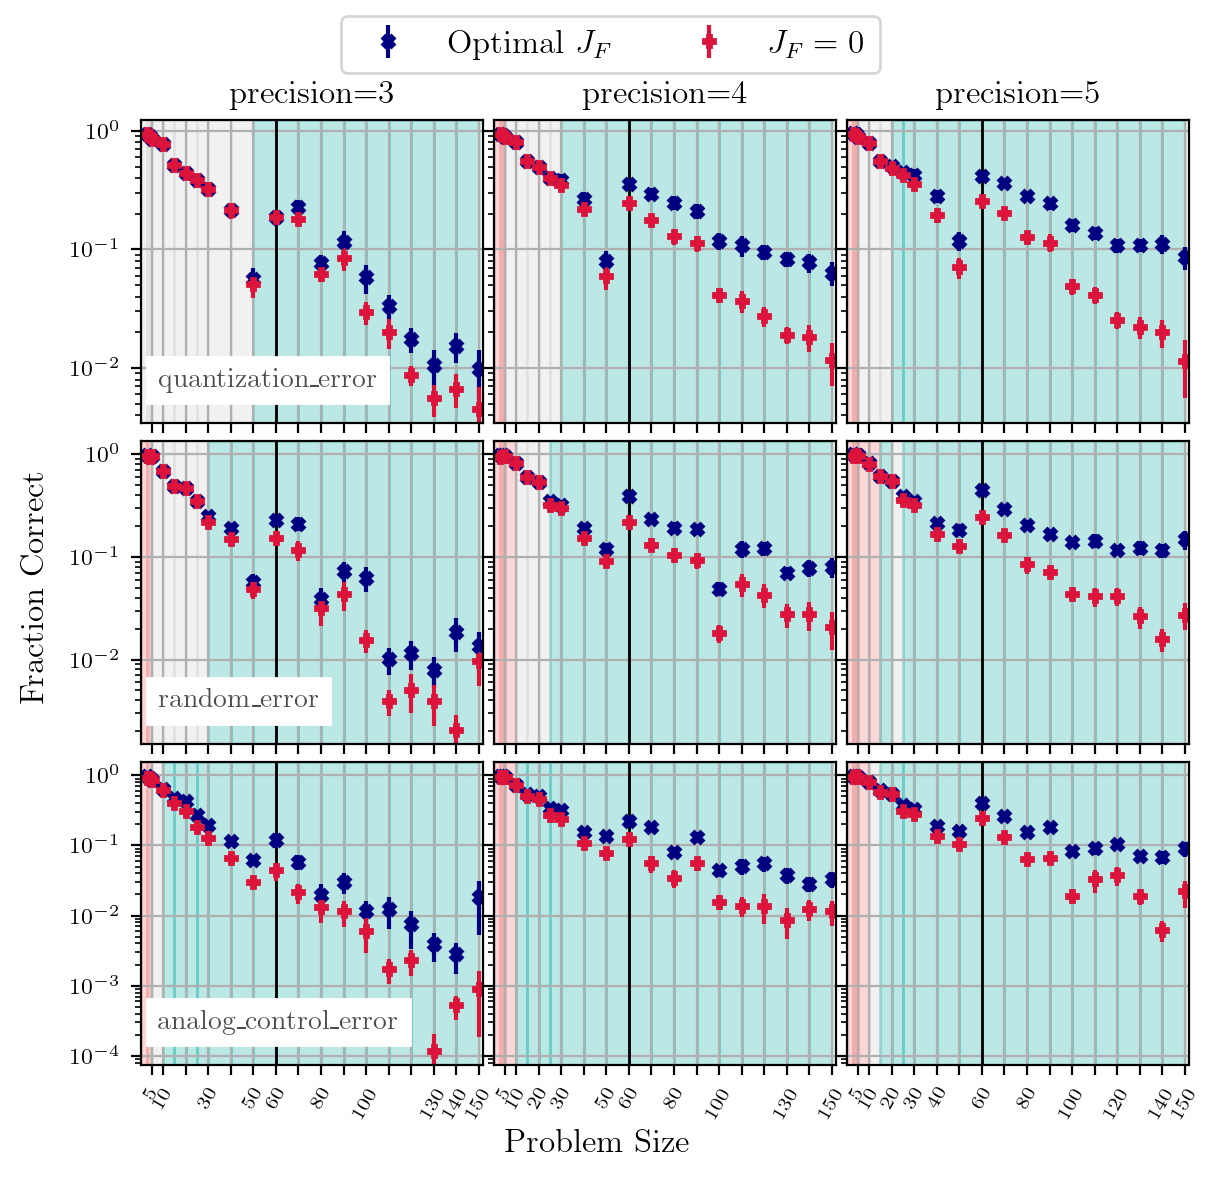

In [11]:
# run the 'Optimal Gamma Values' section cells to obtain the fraction correct and optimal gammas.
figure_size = get_figsize(latex_text_width_pt, text_height_pt=0.7*latex_text_height_pt, aspect_ratio=None)

# there will be three figures one for each precision
figure, axs = plt.subplots(len(error_models), len(precisions), figsize=figure_size, sharex='col', sharey='row',dpi=200)


for row, error_model in enumerate(error_models):
  for col, precision in enumerate(precisions):
    axs[row][col].set_xlim(0,152)
    # set the title for precision    
    if row == 0:
     axs[row][col].set_title(f"precision={precision}")
    # set the yscale and the grid
    axs[row][col].set_yscale('log')
    axs[row][col].grid()
    # specifcy the error model
    if col == 0:
      axs[row][col].text(0.05, 0.1, f"{error_model}", 
                         transform=axs[row][col].transAxes, 
                         va='bottom', ha='left', backgroundcolor='white', 
                         alpha=0.7)
    # outline the point from small to big problem instances
    axs[row][col].axvline(x=60, color='black', linestyle='-', linewidth=1)
    # let's get the problem instance until which the optimal gamma is antiferromagnetic
    L2gamma = {l:optimal_gammas[error_model][l][precision] for l in all_Ls}
    # let's do the range from 0 to 3
    if L2gamma[3] < 0 :
      axs[row][col].axvspan(0, 3, color=antiferro_color, alpha=background_alpha)
    elif L2gamma[3] == 0 :
      axs[row][col].axvspan(0, 3, color=gamma_zero_color, alpha=background_alpha)
    elif L2gamma[3] > 0:
      axs[row][col].axvspan(0, 3, color=ferro_color, alpha=background_alpha)
    
    for Ll in all_Ls:
      for Lr in all_Ls:
        if Ll < Lr:
          if L2gamma[Ll] < 0:
            axs[row][col].axvspan(Ll, Lr, color=antiferro_color, alpha=background_alpha)
          elif L2gamma[Ll] == 0 :
            axs[row][col].axvspan(Ll, Lr, color=gamma_zero_color, alpha=background_alpha)
          elif L2gamma[Ll] > 0:
            axs[row][col].axvspan(Ll, Lr, color=ferro_color, alpha=background_alpha)
          break
    # Fraction correct  Small Instances Optimal Gamma
    FC_SI_OptG = [fraction_corrects_at_optimal_gammas[error_model][L][precision] for L in small_Ls]
    stdev_SI_OptG = [stdevs_at_optimal_gammas[error_model][L][precision] for L in small_Ls]
    # Fraction correct Small Instances 0 Gamma
    FC_SI_0G = [fraction_corrects_at_0_gammas[error_model][L][precision] for L in small_Ls]
    stdev_SI_0G = [stdevs_at_0_gammas[error_model][L][precision] for L in small_Ls]
    # Fraction correct Big Instances Optimal Gamma
    FC_BI_OptG = [fraction_corrects_at_optimal_gammas[error_model][L][precision] for L in big_Ls]
    stdev_BI_OptG = [stdevs_at_optimal_gammas[error_model][L][precision] for L in big_Ls]
    # Fraction correct Big Instances 0 Gamma
    FC_BI_0G = [fraction_corrects_at_0_gammas[error_model][L][precision] for L in big_Ls]
    stdev_BI_0G = [stdevs_at_0_gammas[error_model][L][precision] for L in big_Ls]
    
    if row == 0 and col == 0:
      # Fraction correct  Small Instances Optimal Gamma
      #axs[row][col].plot(small_Ls, FC_SI_OptG, marker=markers['optimal'],
      axs[row][col].errorbar(small_Ls, FC_SI_OptG, xerr=None, yerr=stdev_SI_OptG,
                             marker=markers['optimal'],linestyle=linestyles['optimal'], 
                             label=f"Optimal $J_F$",color=colors['optimal'])
      # Fraction correct  Small Instances 0 Gamma
      #axs[row][col].plot(small_Ls, FC_SI_0G, marker=markers['zero'],
      axs[row][col].errorbar(small_Ls, FC_SI_0G, xerr=None, yerr=stdev_SI_0G,
                             marker=markers['zero'],linestyle=linestyles['zero'], 
                             label=f"$J_F =0$",color=colors['zero'])
      # Fraction correct  Big Instances Optimal Gamma
      #axs[row][col].plot(big_Ls, FC_BI_OptG, marker=markers['optimal'],
      axs[row][col].errorbar(big_Ls, FC_BI_OptG, xerr=None, yerr=stdev_BI_OptG,
                             marker=markers['optimal'],linestyle=linestyles['optimal'],color=colors['optimal'])
      # Fraction correct  Big Instances 0 Gamma
      #axs[row][col].plot(big_Ls, FC_BI_0G, marker=markers['zero'],
      axs[row][col].errorbar(big_Ls, FC_BI_0G, xerr=None, yerr=stdev_BI_0G,
                             marker=markers['zero'],linestyle=linestyles['zero'],color=colors['zero'])
      
    else:
      # Fraction correct  Small Instances Optimal Gamma
      #axs[row][col].plot(small_Ls, FC_SI_OptG, marker=markers['optimal'],
      axs[row][col].errorbar(small_Ls, FC_SI_OptG, xerr=None, yerr=stdev_SI_OptG,
                             marker=markers['optimal'],linestyle=linestyles['optimal'],color=colors['optimal'])
      # Fraction correct  Small Instances 0 Gamma
      #axs[row][col].plot(small_Ls, FC_SI_0G, marker=markers['zero'],
      axs[row][col].errorbar(small_Ls, FC_SI_0G, xerr=None, yerr=stdev_SI_0G,
                             marker=markers['zero'],linestyle=linestyles['zero'],color=colors['zero'])
      # Fraction correct  Big Instances Optimal Gamma
      #axs[row][col].plot(big_Ls, FC_BI_OptG, marker=markers['optimal'],
      axs[row][col].errorbar(big_Ls, FC_BI_OptG, xerr=None, yerr=stdev_BI_OptG,
                             marker=markers['optimal'],linestyle=linestyles['optimal'],color=colors['optimal'])
      # Fraction correct  Big Instances 0 Gamma
      #axs[row][col].plot(big_Ls, FC_BI_0G, marker=markers['zero'],
      axs[row][col].errorbar(big_Ls, FC_BI_0G, xerr=None, yerr=stdev_BI_0G,
                             marker=markers['zero'],linestyle=linestyles['zero'],color=colors['zero'])
      

xticks = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

xlabels_1 = [5,10,30,50,60,80,100,130,140, 150]
new_labels = []
for x in xticks:
  if x in xlabels_1:
    new_labels.append(x)
  else:
    new_labels.append('')
xlabels_1 = new_labels.copy()


xlabels_2 = [5,10,20,30,50,60,80,100,130,150]
new_labels = []
for x in xticks:
  if x in xlabels_2:
    new_labels.append(x)
  else:
    new_labels.append('')
xlabels_2 = new_labels.copy()

xlabels_3 = [5,10,20,30,40,60,80,100, 120, 140, 150]
new_labels = []
for x in xticks:
  if x in xlabels_3:
    new_labels.append(x)
  else:
    new_labels.append('')
xlabels_3 = new_labels.copy()

labelsize = 7

axs[2][0].set_xticks(xticks, labels=xlabels_1) 
axs[2][0].tick_params(axis='x', rotation=60, labelsize=labelsize) 

axs[2][1].set_xticks(xticks, labels=xlabels_2) 
axs[2][1].tick_params(axis='x', rotation=60, labelsize=labelsize) 

axs[2][2].set_xticks(xticks, labels=xlabels_3) 
axs[2][2].tick_params(axis='x', rotation=60, labelsize=labelsize) 

# we manually set the x ticks 
figure.supxlabel("Problem Size")
figure.supylabel("Fraction Correct")
figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.12, right=0.99, bottom=0.09, top=0.9, wspace=0.03, hspace=0.06)

In [ ]:
#figure.savefig("./figures_to_thesis/fraction_correct_optimal_gamma.pdf", format='pdf', dpi=300)

### Information Printing

In [32]:
print("The smallest/largest change in fraction correct for optimal J_F from L=50 to L=60")
largest_change = 0
smallest_change = 99999
largest_em, largest_pr, largest_std = None, None, None
smallest_em, smallest_pr, smallest_std = None, None, None


for error_model in error_models:
  for precision in [3,4,5]:
    
    fc_50 = fraction_corrects_at_optimal_gammas[error_model][50][precision]
    std_50 = stdevs_at_optimal_gammas[error_model][50][precision]

    fc_60 = fraction_corrects_at_optimal_gammas[error_model][60][precision]
    std_60 = fraction_corrects_at_optimal_gammas[error_model][60][precision]


    change = ((fc_60 - fc_50) / fc_50) * 100
    std_change = np.sqrt(((100 / fc_50) * std_60) ** 2 + ((-100 * fc_60 / (fc_50 ** 2)) * std_50) ** 2)

    if change > largest_change:
      largest_change = change
      largest_std = std_change
      largest_em, largest_pr = error_model, precision

    if change < smallest_change:
      smallest_change = change
      smallest_std = std_change
      smallest_em, smallest_pr = error_model, precision

print(f"Largest change EM={largest_em} at pr={largest_pr} from {fraction_corrects_at_optimal_gammas[largest_em][50][largest_pr]} +- {stdevs_at_optimal_gammas[largest_em][50][largest_pr]} to {fraction_corrects_at_optimal_gammas[largest_em][60][largest_pr]} +- {stdevs_at_optimal_gammas[largest_em][60][largest_pr]}")
print(f"Smallest change EM={smallest_em} at pr={smallest_pr} from {fraction_corrects_at_optimal_gammas[smallest_em][50][smallest_pr]} +- {stdevs_at_optimal_gammas[smallest_em][50][smallest_pr]} to {fraction_corrects_at_optimal_gammas[smallest_em][60][smallest_pr]} +- {stdevs_at_optimal_gammas[smallest_em][60][smallest_pr]}")

The smallest/largest change in fraction correct for optimal J_F from L=50 to L=60
Largest change EM=quantization_error.3f at pr=4 from 0.07922000000000003 +- 0.01780537922235022 to 0.35586666666666666 +- 0.03354998437029685
Smallest change EM=analog_control_error at pr=4 from 0.13471000000000002 +- 0.019863317263923295 to 0.22119999999999998 +- 0.024365545262077896


In [28]:
print("How the difference between the fraction correct for optimal JF and JF=0 increases with the problem size.")
em, pr = acem, 5

for L in [3,150]:  
  fc_optimal = fraction_corrects_at_optimal_gammas[em][L][pr]
  std_optimal = stdevs_at_optimal_gammas[em][L][pr]

  fc_0 = fraction_corrects_at_0_gammas[em][L][pr]
  std_0 = stdevs_at_0_gammas[em][L][pr]
  
  improvement = ((fc_optimal - fc_0) / fc_0) * 100
  stdev_improvement = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)

  print(f"L={L}, at optimal JF={fc_optimal} +- {std_optimal}  at zero JF = {fc_0} +- {std_0} which is a {improvement} +- {stdev_improvement}% improvement")


How the difference between the fraction correct for optimal JF and JF=0 increases with the problem size.
L=3, at optimal JF=0.9922 +- 0.0018766507884575051  at zero JF = 0.9499000000000001 +- 0.010500596423657336 which is a 4.45310032635013 +- 1.171448278777599% improvement
L=150, at optimal JF=0.09101960784313728 +- 0.02164654351948946  at zero JF = 0.022196078431372567 +- 0.009292971441414454 which is a 310.0706713780916 +- 197.45213102244176% improvement


In [70]:
print(f"The best improvements in fraction correct, i.e. the largest difference between the optimal JF and the JF=0 cases.")

for error_model in error_models:
  print(error_model)
  for precision in [3,4,5]:
    print(f"\tprecision={precision}")
    best_improvement = 0
    best_improvement_L = -1
    best_improvement_stdev = 0

    for L in all_Ls:
      fc_optimal = fraction_corrects_at_optimal_gammas[error_model][L][precision]
      std_optimal = stdevs_at_optimal_gammas[error_model][L][precision]

      fc_0 = fraction_corrects_at_0_gammas[error_model][L][precision]
      std_0 = stdevs_at_0_gammas[error_model][L][precision]
      
      improvement = ((fc_optimal - fc_0) / fc_0) * 100
      stdev_improvement = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)
      #sigma_improvement = sigma_improvement ** 0.5
            
      if improvement > best_improvement:
        best_improvement = improvement
        best_improvement_L = L
        best_improvement_stdev = stdev_improvement

    print(f"\t\tBest improvement = {best_improvement}% +- {best_improvement_stdev} for L={best_improvement_L} lower ={best_improvement - best_improvement_stdev} upper={best_improvement + best_improvement_stdev}")

Let's print out the best improvements in fraction correct 
quantization_error
	precision=3
		Best improvement = 129.5634920634921% +- 98.45532227995702 for L=140 lower =31.10816978353509 upper=228.01881434344912
	precision=4
		Best improvement = 444.7982339253377% +- 245.63159654722048 for L=150 lower =199.1666373781172 upper=690.4298304725581
	precision=5
		Best improvement = 653.2786885245899% +- 416.91828097806797 for L=150 lower =236.36040754652197 upper=1070.1969695026578
random_error
	precision=3
		Best improvement = 801.290322580645% +- 474.6748148741676 for L=140 lower =326.6155077064774 upper=1275.9651374548125
	precision=4
		Best improvement = 290.525632706035% +- 179.402006250259 for L=150 lower =111.12362645577602 upper=469.927638956294
	precision=5
		Best improvement = 627.7591973244145% +- 215.83588332689723 for L=140 lower =411.9233139975172 upper=843.5950806513117
analog_control_error
	precision=3
		Best improvement = 3244.444444444445% +- 2887.044425429455 for L=130 lo

## No Errrors

We used an annealing time $0.5 \mu s$ with $100$ number of reads for $L < 60$ and $5.0 \mu s$ with $1000$ number of reads for $L \geq 60$. 
For each problem size, we ran $100$ different problem instances.
$J_F \in \{ -0.3 , -0.24, -0.18, -0.12, -0.06,  0.  ,  0.06,  0.12,  0.18, 0.24,  0.3 \}$.
Precision is set to $-1$ since it is not used for this set of results and to make use of the ResultsManager and FitnessManager classes.

### Small Instances JF Sampling

In [32]:
# Define the results to load
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']

Ls = [3,4,5,10,15,20,25,30,40,50]
AT = 0.5
error_models = ['no_error']
precisions = [-1]
seeds = {'no_error':range(100)}

problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [9]:
# # Load the results into the results manager
# results_manager = ResultsManager(sampler_ids, Ls, error_models=error_models, precisions=precisions,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [10]:
# with open("./FM_no-error_small_instances.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [33]:
with open("./FM_no-error_small_instances.pickle", 'rb') as f:
  results_manager = pickle.load(f)

In [11]:
# # calculate fitnesses
# fitness_manager = FitnessManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, results_manager=results_manager,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [12]:
# fitness_manager.calculate_all_fitnesses(results_manager)

In [17]:
# with open('./FM_no-error_small_instances.pickle', 'wb') as f:
#  pickle.dump(fitness_manager, f)

In [34]:
with open('./FM_no-error_small_instances.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [35]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = fitness_manager.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=AT,
                                                                                                      seeds=seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [36]:
L_label_x = {}
L_label_y = {}
for L in Ls:
  if L < 5:
    # put it at the lower left
    L_label_x[L] = 0.02
    L_label_y[L] = 0.12
  else:
    # put it to upper left
    L_label_x[L] = 0.02
    L_label_y[L] = 0.65

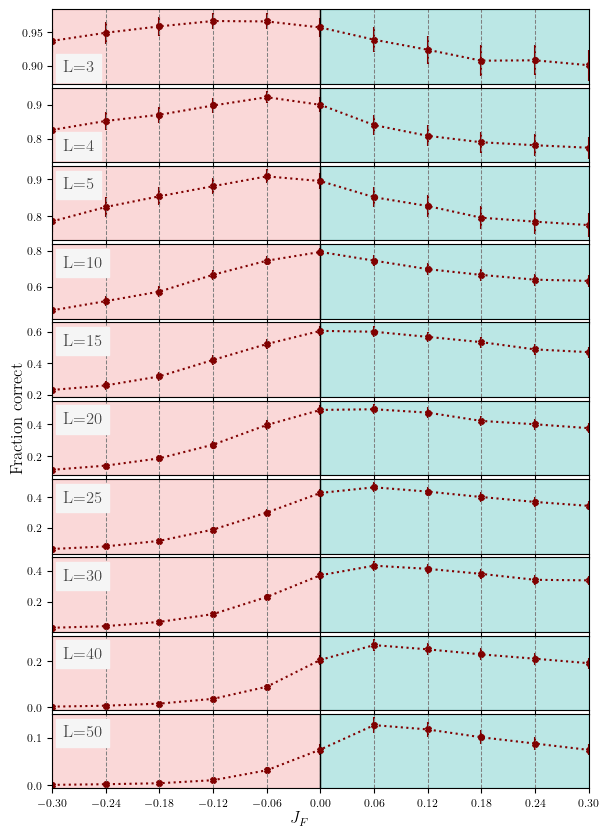

In [37]:
figure_size = get_figsize(latex_text_width_pt, text_height_pt=latex_text_height_pt, aspect_ratio=None)

figure, axs = plt.subplots(len(Ls), 1, figsize=figure_size, sharex='col', sharey='row')

precision = -1
for row, L in enumerate(Ls):
  axs[row].text(L_label_x[L], L_label_y[L], f"L={L}",
                      transform=axs[row].transAxes, 
                      va='bottom', ha='left', backgroundcolor='whitesmoke',
                      alpha=0.7, fontsize=12)

  for error_model in error_models:
    x_axis = np.array(gamma_ranges[error_model][precision]) 
    if row == 0 :
      axs[row].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                          xerr=None, yerr=stdevs[error_model][L][precision], 
                          marker=markers[error_model], linestyle=linestyles[error_model], 
                          color=colors[error_model], label=f"{error_model}")
    else:
      axs[row].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                          xerr=None, yerr=stdevs[error_model][L][precision], 
                          marker=markers[error_model], linestyle=linestyles[error_model],
                          color=colors[error_model])

# set up the grid
for row, L in enumerate(Ls):
  gamma_range = np.array(gamma_ranges[error_model][precision]) 
  # Draw horizontal grid lines at specified x values
  for gamma in gamma_range:
      axs[row].axvline(x=gamma, color='gray', linestyle='--', linewidth=0.75)

  axs[row].set_xticks(gamma_range)

  # let's also paint the background
  axs[row].axvspan(gamma_lower_limit, 0, color=antiferro_color, alpha=background_alpha)
  axs[row].axvline(x=0, color='black', linestyle='-', linewidth=1)
  axs[row].axvspan(0, gamma_upper_limit, color=ferro_color, alpha=background_alpha)
  axs[row].set_xlim(gamma_lower_limit, gamma_upper_limit)

figure.supxlabel("$J_F$")
figure.supylabel("Fraction correct")
plt.subplots_adjust(left=0.09, right=0.98, bottom=0.055, top=0.99, wspace=0.03, hspace=0.05)

In [38]:
#figure.savefig("./figures_to_thesis/no-error_gamma_sampling_small.pdf", format='pdf', dpi=300)

### Big Instances JF Sampling

In [15]:
# Define the results to load
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
Ls = [60,70,80,90,100,110,120,130,140,150]
AT = 5
error_models = ['no_error']
precisions = [-1]
seeds = {'no_error':range(100)}

problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [ ]:
# # Load the results into the results manager
# results_manager = ResultsManager(sampler_ids, Ls, error_models=error_models, precisions=precisions,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [ ]:
# with open("./FM_no-error_big_instances.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [17]:
with open("./FM_no-error_big_instances.pickle", 'rb') as f:
  results_manager = pickle.load(f)

In [12]:
# # calculate fitnesses
# fitness_manager = FitnessManager(sampler_ids, Ls, error_models=error_models, precisions=precisions, results_manager=results_manager,
#                                 seeds=seeds, problem_types=[problem_type], ATs=[AT], main_directory=main_directory)

In [13]:
# fitness_manager.calculate_all_fitnesses(results_manager)

In [14]:
# with open('./FM_no-error_big_instances.pickle', 'wb') as f:
#  pickle.dump(fitness_manager, f)

In [18]:
with open('./FM_no-error_big_instances.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [19]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = fitness_manager.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=AT,
                                                                                                      seeds=seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [20]:
L_label_x = {}
L_label_y = {}
for L in Ls:
  if L < 5:
    # put it at the lower left
    L_label_x[L] = 0.02
    L_label_y[L] = 0.12
  else:
    # put it to upper left
    L_label_x[L] = 0.02
    L_label_y[L] = 0.65

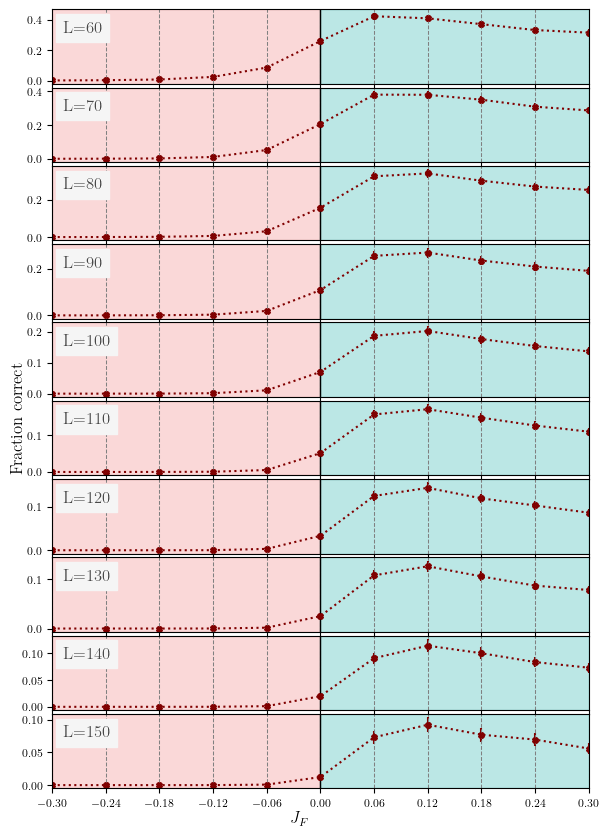

In [24]:
figure_size = get_figsize(latex_text_width_pt, text_height_pt=latex_text_height_pt, aspect_ratio=None)

figure, axs = plt.subplots(len(Ls), 1, figsize=figure_size, sharex='col', sharey='row')

precision = -1
for row, L in enumerate(Ls):
  axs[row].text(L_label_x[L], L_label_y[L], f"L={L}",
                      transform=axs[row].transAxes, 
                      va='bottom', ha='left', backgroundcolor='whitesmoke',
                      alpha=0.7, fontsize=12)

  for error_model in error_models:
    x_axis = np.array(gamma_ranges[error_model][precision]) 
    if row == 0 :
      axs[row].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                          xerr=None, yerr=stdevs[error_model][L][precision], 
                          marker=markers[error_model], linestyle=linestyles[error_model], 
                          color=colors[error_model], label=f"{error_model}")
    else:
      axs[row].errorbar(x_axis, fraction_corrects[error_model][L][precision], 
                          xerr=None, yerr=stdevs[error_model][L][precision], 
                          marker=markers[error_model], linestyle=linestyles[error_model],
                          color=colors[error_model])
# set up the grid
for row, L in enumerate(Ls):
  gamma_range = np.array(gamma_ranges[error_model][precision]) 
  # Draw horizontal grid lines at specified x values
  for gamma in gamma_range:
      axs[row].axvline(x=gamma, color='gray', linestyle='--', linewidth=0.75)

  axs[row].set_xticks(gamma_range)

  # let's also paint the background
  axs[row].axvspan(gamma_lower_limit, 0, color=antiferro_color, alpha=background_alpha)
  axs[row].axvline(x=0, color='black', linestyle='-', linewidth=1)
  axs[row].axvspan(0, gamma_upper_limit, color=ferro_color, alpha=background_alpha)
  axs[row].set_xlim(gamma_lower_limit, gamma_upper_limit)

figure.supxlabel("$J_F$")
figure.supylabel("Fraction correct")
plt.subplots_adjust(left=0.09, right=0.98, bottom=0.055, top=0.99, wspace=0.03, hspace=0.05)

In [25]:
#figure.savefig("./figures_to_thesis/no-error_gamma_sampling_big.pdf", format='pdf', dpi=300)

## Optimal vs Zero JF

In [39]:
with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_no-error_small_instances.pickle", "rb") as f:
  FM_small = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_no-error_big_instances.pickle", "rb") as f:
  FM_big = pickle.load(f)

# the parameters for the small problem instances
small_Ls = [3,4,5,10,15,20,25,30,40,50]
small_AT = 0.5
small_seeds = {'no_error':range(100)}

# parameters for big problem instances
big_Ls = [60,70,80,90,100,110,120,130,140,150]
big_AT = 5
big_seeds = {'no_error':range(100)}

# common params
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
error_models = ['no_error']
precision = -1
precisions = [-1]
all_Ls = [3,4,5,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150]
 
problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [40]:
# [error_model][L][precision] -> [fraction corrects sorted by gammas]
fraction_corrects = {}
stdevs = {}
# [error_model][precision] = [relevant gamma range]
gamma_ranges = {}

for error_model in error_models: 
  fraction_corrects[error_model], stdevs[error_model], gamma_ranges[error_model] = {}, {}, {}
  for L in small_Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = FM_small.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=small_AT,
                                                                                                      seeds=small_seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)
  for L in big_Ls:
    # these will be dictionaries indexed by precision
    fraction_corrects[error_model][L], stdevs[error_model][L], gamma_ranges[error_model] = FM_big.get_fraction_correct(sampler_id=sampler_ids[0], 
                                                                                                      precisions=precisions,
                                                                                                      L=L,
                                                                                                      error_model=error_model,
                                                                                                      method='AL-1',
                                                                                                      AT=big_AT,
                                                                                                      seeds=big_seeds[error_model],
                                                                                                      return_gamma_ranges=True,
                                                                                                      return_stdev=True)

In [41]:
# let's calculate the optimal gamma values
# [error_model][L][precision] -> optimal gamma value 
optimal_gammas = {}
for error_model in error_models:
  optimal_gammas[error_model] = {}
  for L in all_Ls:
    optimal_gammas[error_model][L] = {}
    for precision in precisions:
      optimal_gamma_index = np.argmax(fraction_corrects[error_model][L][precision])
      optimal_gammas[error_model][L][precision] = gamma_ranges[error_model][precision][optimal_gamma_index]

In [42]:
# let's filter the fraction correct at optimal gamma values
# [error_model][L][precision] -> fraction correct at optimal gamma value
fraction_corrects_at_optimal_gammas = {}
stdevs_at_optimal_gammas = {}
# similarly for 0 gamma
fraction_corrects_at_0_gammas = {}
stdevs_at_0_gammas = {}
for error_model in error_models:
  fraction_corrects_at_optimal_gammas[error_model] = {}
  fraction_corrects_at_0_gammas[error_model] = {}
  stdevs_at_optimal_gammas[error_model] = {}
  stdevs_at_0_gammas[error_model] = {}
  for L in all_Ls:
    fraction_corrects_at_optimal_gammas[error_model][L] = {}
    fraction_corrects_at_0_gammas[error_model][L] = {}
    stdevs_at_optimal_gammas[error_model][L] = {}
    stdevs_at_0_gammas[error_model][L] = {}
    for precision in precisions:
      optimal_gamma_index = np.argmax(fraction_corrects[error_model][L][precision])
      fraction_corrects_at_optimal_gammas[error_model][L][precision] = fraction_corrects[error_model][L][precision][optimal_gamma_index]
      stdevs_at_optimal_gammas[error_model][L][precision] = stdevs[error_model][L][precision][optimal_gamma_index]

      gamma_0_index = gamma_ranges[error_model][precision].index(0)
      fraction_corrects_at_0_gammas[error_model][L][precision] = fraction_corrects[error_model][L][precision][gamma_0_index]
      stdevs_at_0_gammas[error_model][L][precision] = stdevs[error_model][L][precision][gamma_0_index]

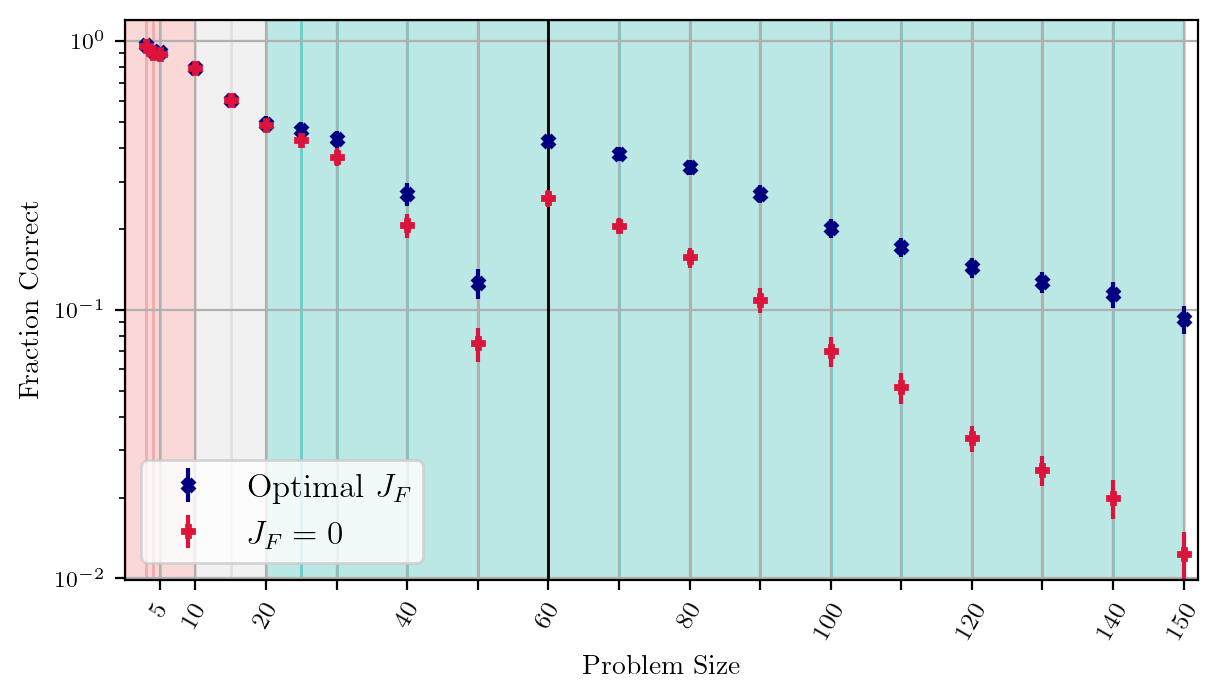

In [55]:
# run the 'Optimal Gamma Values' section cells to obtain the fraction correct and optimal gammas.
figure_size = get_figsize(latex_text_width_pt, text_height_pt=0.4*latex_text_height_pt, aspect_ratio=None)

# there will be three figures one for each precision
figure, ax = plt.subplots(1,1, figsize=figure_size, sharex='col', sharey='row',dpi=200)

error_model = 'no_error'
precision = -1

ax.set_xlim(0,152)
# set the yscale and the grid
ax.set_yscale('log')
ax.grid()

# outline the point from small to big problem instances
ax.axvline(x=60, color='black', linestyle='-', linewidth=1)
# let's get the problem instance until which the optimal gamma is antiferromagnetic
L2gamma = {l:optimal_gammas[error_model][l][precision] for l in all_Ls}
# let's do the range from 0 to 3
if L2gamma[3] < 0 :
  ax.axvspan(0, 3, color=antiferro_color, alpha=background_alpha)
elif L2gamma[3] == 0 :
  ax.axvspan(0, 3, color=gamma_zero_color, alpha=background_alpha)
elif L2gamma[3] > 0:
  ax.axvspan(0, 3, color=ferro_color, alpha=background_alpha)

for Ll in all_Ls:
  for Lr in all_Ls:
    if Ll < Lr:
      if L2gamma[Ll] < 0:
        ax.axvspan(Ll, Lr, color=antiferro_color, alpha=background_alpha)
      elif L2gamma[Ll] == 0 :
        ax.axvspan(Ll, Lr, color=gamma_zero_color, alpha=background_alpha)
      elif L2gamma[Ll] > 0:
        ax.axvspan(Ll, Lr, color=ferro_color, alpha=background_alpha)
      break
# Fraction correct  Small Instances Optimal Gamma
FC_SI_OptG = [fraction_corrects_at_optimal_gammas[error_model][L][precision] for L in small_Ls]
stdev_SI_OptG = [stdevs_at_optimal_gammas[error_model][L][precision] for L in small_Ls]
# Fraction correct Small Instances 0 Gamma
FC_SI_0G = [fraction_corrects_at_0_gammas[error_model][L][precision] for L in small_Ls]
stdev_SI_0G = [stdevs_at_0_gammas[error_model][L][precision] for L in small_Ls]
# Fraction correct Big Instances Optimal Gamma
FC_BI_OptG = [fraction_corrects_at_optimal_gammas[error_model][L][precision] for L in big_Ls]
stdev_BI_OptG = [stdevs_at_optimal_gammas[error_model][L][precision] for L in big_Ls]
# Fraction correct Big Instances 0 Gamma
FC_BI_0G = [fraction_corrects_at_0_gammas[error_model][L][precision] for L in big_Ls]
stdev_BI_0G = [stdevs_at_0_gammas[error_model][L][precision] for L in big_Ls]


# Fraction correct  Small Instances Optimal Gamma
ax.errorbar(small_Ls, FC_SI_OptG, xerr=None, yerr=stdev_SI_OptG,
                        marker=markers['optimal'],linestyle=linestyles['optimal'], 
                        label=f"Optimal $J_F$",color=colors['optimal'])
# Fraction correct  Small Instances 0 Gamma
ax.errorbar(small_Ls, FC_SI_0G, xerr=None, yerr=stdev_SI_0G,
                        marker=markers['zero'],linestyle=linestyles['zero'], 
                        label=f"$J_F =0$",color=colors['zero'])
# Fraction correct  Big Instances Optimal Gamma
ax.errorbar(big_Ls, FC_BI_OptG, xerr=None, yerr=stdev_BI_OptG,
                        marker=markers['optimal'],linestyle=linestyles['optimal'],color=colors['optimal'])
# Fraction correct  Big Instances 0 Gamma
ax.errorbar(big_Ls, FC_BI_0G, xerr=None, yerr=stdev_BI_0G,
                        marker=markers['zero'],linestyle=linestyles['zero'],color=colors['zero'])

    

xticks = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

xlabels_1 = [5,10,20,40,60,80,100,120,140,150]
new_labels = []
for x in xticks:
  if x in xlabels_1:
    new_labels.append(x)
  else:
    new_labels.append('')
xlabels_1 = new_labels.copy()

labelsize = 9

ax.set_xticks(xticks, labels=xlabels_1) 
ax.tick_params(axis='x', rotation=60, labelsize=labelsize) 

# we manually set the x ticks 
ax.set_xlabel("Problem Size")
ax.set_ylabel("Fraction Correct")
ax.legend(loc='lower left')
plt.subplots_adjust(left=0.1, right=0.99, bottom=0.15, top=0.99, wspace=0.03, hspace=0.06)

In [56]:
#figure.savefig("./figures_to_thesis/no-error_optimal_vs_zero_gamma.pdf", format='pdf', dpi=300)

### Information Printing

In [60]:
print("The smallest/largest change in fraction correct for optimal J_F from L=50 to L=60")
precision = -1
error_model = 'no_error'

fc_50 = fraction_corrects_at_optimal_gammas[error_model][50][precision]
std_50 = stdevs_at_optimal_gammas[error_model][50][precision]

fc_60 = fraction_corrects_at_optimal_gammas[error_model][60][precision]
std_60 = fraction_corrects_at_optimal_gammas[error_model][60][precision]


change = ((fc_60 - fc_50) / fc_50) * 100
std_change = np.sqrt(((100 / fc_50) * std_60) ** 2 + ((-100 * fc_60 / (fc_50 ** 2)) * std_50) ** 2)


print(f"Changes from {fc_50} +- {std_50} to {fc_60} +- {std_60}")


The smallest/largest change in fraction correct for optimal J_F from L=50 to L=60
Changes from 0.12590000000000004 +- 0.01630584886078328 to 0.42291000000000023 +- 0.42291000000000023


In [63]:
print("How the difference between the fraction correct for optimal JF and JF=0 increases with the problem size.")
em, pr = 'no_error', -1

for L in [3,150]:  
  fc_optimal = fraction_corrects_at_optimal_gammas[em][L][pr]
  std_optimal = stdevs_at_optimal_gammas[em][L][pr]

  fc_0 = fraction_corrects_at_0_gammas[em][L][pr]
  std_0 = stdevs_at_0_gammas[em][L][pr]
  
  improvement = ((fc_optimal - fc_0) / fc_0) * 100
  stdev_improvement = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)

  print(f"L={L}, at optimal JF={fc_optimal} +- {std_optimal}  at zero JF = {fc_0} +- {std_0} which is a {improvement} +- {stdev_improvement}% improvement")


How the difference between the fraction correct for optimal JF and JF=0 increases with the problem size.
L=3, at optimal JF=0.9671000000000001 +- 0.012435932785377388  at zero JF = 0.9573999999999999 +- 0.014221636667238743 which is a 1.0131606434092495 +- 1.9846142230232444% improvement
L=150, at optimal JF=0.09222000000000007 +- 0.01132694632861449  at zero JF = 0.012320000000000006 +- 0.0025706533383283315 which is a 648.5389610389611 +- 181.23882771278224% improvement


In [67]:
print(f"The best improvements in fraction correct, i.e. the largest difference between the optimal JF and the JF=0 cases.")

error_model = 'no_error'
precision = -1


best_improvement = 0
best_improvement_L = -1
best_improvement_stdev = 0

for L in all_Ls:
  fc_optimal = fraction_corrects_at_optimal_gammas[error_model][L][precision]
  std_optimal = stdevs_at_optimal_gammas[error_model][L][precision]

  fc_0 = fraction_corrects_at_0_gammas[error_model][L][precision]
  std_0 = stdevs_at_0_gammas[error_model][L][precision]
  
  improvement = ((fc_optimal - fc_0) / fc_0) * 100
  stdev_improvement = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)
  #sigma_improvement = sigma_improvement ** 0.5
  print(f"\t\t L={L} the improvement = {improvement}% +- {stdev_improvement} lower ={improvement - stdev_improvement} upper={improvement + stdev_improvement}")

  if improvement > best_improvement:
    best_improvement = improvement
    best_improvement_L = L
    best_improvement_stdev = stdev_improvement

print(f"Best improvement = {best_improvement}% +- {best_improvement_stdev} for L={best_improvement_L} lower ={best_improvement - best_improvement_stdev} upper={best_improvement + best_improvement_stdev}")

The best improvements in fraction correct, i.e. the largest difference between the optimal JF and the JF=0 cases.
		 L=3 the improvement = 1.0131606434092495% +- 1.9846142230232444 lower =-0.9714535796139949 upper=2.997774866432494
		 L=4 the improvement = 2.4683122081387463% +- 3.2421036797746283 lower =-0.773791471635882 upper=5.710415887913374
		 L=5 the improvement = 1.4081358962896673% +- 3.162159677353565 lower =-1.754023781063898 upper=4.570295573643232
		 L=10 the improvement = 0.0% +- 4.3058235012840065 lower =-4.3058235012840065 upper=4.3058235012840065
		 L=15 the improvement = 0.0% +- 7.392122921754615 lower =-7.392122921754615 upper=7.392122921754615
		 L=20 the improvement = 0.8793456032719659% +- 8.999722220452615 lower =-8.120376617180648 upper=9.879067823724581
		 L=25 the improvement = 8.593386120167697% +- 10.277211755357042 lower =-1.6838256351893452 upper=18.870597875524737
		 L=30 the improvement = 16.64418667386025% +- 12.438392433197633 lower =4.205794240662618 

## Number of Reads Table


In [6]:
def get_num_reads(fitness_manager: FitnessManager, results_manager:ResultsManager):

    # initialize the dictionary
    all_num_reads = {}
    for problem_type in fitness_manager.problem_types:
      all_num_reads[problem_type] = {}
      for error_model in fitness_manager.error_models:
        all_num_reads[problem_type][error_model] = {}
        for sampler_id in fitness_manager.sampler_ids:
          all_num_reads[problem_type][error_model][sampler_id] = {}
          for precision in fitness_manager.precisions:
            all_num_reads[problem_type][error_model][sampler_id][precision] = {}
            for L in fitness_manager.Ls:
              all_num_reads[problem_type][error_model][sampler_id][precision][L] = {}
              for seed in fitness_manager.seeds[error_model]:
                all_num_reads[problem_type][error_model][sampler_id][precision][L][seed] = {}
                for AT in fitness_manager.ATs:
                  all_num_reads[problem_type][error_model][sampler_id][precision][L][seed][AT] = {}
                  for gamma in fitness_manager.gamma_ranges[error_model][precision]:
                    all_num_reads[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = 0
    # calculate the number of reads
    for problem_type in fitness_manager.problem_types:
      for error_model in fitness_manager.error_models:
        for sampler_id in fitness_manager.sampler_ids:
          for precision in fitness_manager.precisions:
            for AT in fitness_manager.ATs:
              for L in fitness_manager.Ls:
                for seed in fitness_manager.seeds[error_model]:
                  for gamma in fitness_manager.gamma_ranges[error_model][precision]:
                    # get the results
                    result = results_manager.get_results(sampler_id=sampler_id, L=L, seed=seed,
                                                      precision=precision, error_model=error_model, 
                                                      problem_type=problem_type, AT=AT, gamma=gamma)
                    
                    if type(result) == pd.DataFrame:
                      as_pandas = True
                      if error_model in ['quantization_error', 'no_error']:
                        num_reads_list = [sum(result['num_occurrences'])]
                      else:
                        # we will have a list of num_reads, one for each instance
                        # this will hold the row index while iterating the rows
                        rows_to_skip = []
                        num_reads_list = []
                        nr = 0
                        for row_index, row in result.iterrows():
                          if row['num_occurrences'] == 'NEW_DATA_SET':
                            num_reads_list.append(nr)
                            rows_to_skip.append(row_index)
                            nr = 0
                          else:
                            nr += int(row['num_occurrences'])
                        num_reads_list.append(nr)
                      
                      all_num_reads[problem_type][error_model][sampler_id][precision][L][seed][AT][gamma] = int(np.mean(num_reads_list))
    
    return  all_num_reads

In [77]:
def generate_latex_table_multi_error(all_num_reads, sampler_id, problem_type, error_models, single_precision: bool = False):
    # Initialize a dictionary to store the summary of reads
    summary_data = []

    # Iterate through each error model to collect data
    for error_model in error_models:
        unique_reads_summary = {}

        # Aggregate reads and collect precision (p), L, and seed (s) values, and potentially AT
        for precision, L_data in all_num_reads[problem_type][error_model][sampler_id].items():
            for L, seed_data in L_data.items():
                for seed, AT_data in seed_data.items():
                    for AT, gamma_data in AT_data.items():
                        total_reads = sum(gamma_data.values())
                        gamma_count = len(gamma_data)
                        if gamma_count > 0:
                            avg_reads = int(total_reads / gamma_count)  # Calculate average and convert to integer
                            if avg_reads not in unique_reads_summary:
                                unique_reads_summary[avg_reads] = {'precisions': set(), 'Ls': set(), 'seeds': set(), 'ATs': set()}
                            unique_reads_summary[avg_reads]['precisions'].add(precision)
                            unique_reads_summary[avg_reads]['Ls'].add(L)
                            unique_reads_summary[avg_reads]['seeds'].add(seed)
                            if single_precision:
                                unique_reads_summary[avg_reads]['ATs'].add(float(AT))

        # Store data for each error model in summary_data
        for num_reads, params in unique_reads_summary.items():
            precisions_str = ', '.join(map(str, sorted(params['precisions'])))
            Ls_str = ', '.join(map(str, sorted(params['Ls'])))
            seeds_str = ', '.join(map(str, sorted(params['seeds'])))
            ATs_str = ', '.join(map(str, sorted(params['ATs'])))
            # Format Cartesian product
            if single_precision:
                cartesian_product = f"$(L, s, AT) \\in \\{{{Ls_str}\\}} \\times \\{{{seeds_str}\\}} \\times \\{{{ATs_str} \\ \\mu s \\}}$"
            else:
                cartesian_product = f"$(p, L, s) \\in \\{{{precisions_str}\\}} \\times \\{{{Ls_str}\\}} \\times \\{{{seeds_str}\\}}$"
            
            summary_data.append((error_model, num_reads, cartesian_product))
    
    # Generate LaTeX table
    latex_table = "\\begin{tabular}{|l|l|l|}\n\\hline\nError Model & Num Reads & Parameters \\\\\n\\hline\n"
    for error_model, num_reads, parameters in sorted(summary_data, key=lambda x: (x[0], x[1])):
        latex_table += f"{error_model} & {num_reads} & {parameters} \\\\\n\\hline\n"
    latex_table += "\\end{tabular}"

    return latex_table

In [7]:
with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_small_instances.pickle", "rb") as f:
  FM_small = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/RM_small_instances.pickle", "rb" ) as f:
  RM_small = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_big_instances.pickle", "rb") as f:
  FM_big = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/RM_big_instances.pickle", "rb" ) as f:
  RM_big = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_AT_scan.pickle", "rb") as f:
  FM_AT_scan = pickle.load(f)

with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/RM_AT_scan.pickle") as f:
  RM_AT_scan = pickle.load(f)
 
# the parameters for the small problem instances
small_Ls = [3,4,5,10,15,20,25,30,40,50]
small_AT = 0.5
small_seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

# parameters for big problem instances
big_Ls = [60,70,80,90,100,110,120,130,140,150]
big_AT = 5
big_seeds = {'quantization_error': range(50), 'random_error': range(10), 'analog_control_error': range(10)}

# common params
sampler_ids = ["Advantage_system5.4"]
regions = ['eu-central-1']
error_models = ['quantization_error', 'random_error', 'analog_control_error']
precisions = [3,4,5]
all_Ls = [3,4,5,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150]
 
problem_type = 'triangle_direct'
main_directory = "/Users/beratyenilen/Desktop/Thesis/CODE/scripts/1D_Ising_Chain"

In [81]:
big_num_reads = get_num_reads(FM_big, RM_big)


In [ ]:
small_num_reads = get_num_reads(FM_small, RM_small)
big_num_reads = get_num_reads(FM_big, RM_big)
AT_scan_num_reads = get_num_reads(FM_AT_scan, RM_AT_scan)

In [68]:
print("Small Instances Gamma Sampling")
print(generate_latex_table_multi_error(small_num_reads, "Advantage_system5.4", "triangle_direct", [qem, rem, acem]))

Small Instances Gamma Sampling


In [82]:
print("Big Instances Gamma Sampling")
print(generate_latex_table_multi_error(big_num_reads, "Advantage_system5.4", "triangle_direct", [qem, rem, acem]))

Big Instances Gamma Sampling
\begin{tabular}{|l|l|l|}
\hline
Error Model & Num Reads & Parameters \\
\hline
analog_control_error & 300 & $(p, L, s) \in \{3, 4, 5\} \times \{70, 80, 90, 100, 110, 120, 130, 140, 150\} \times \{6, 7, 8, 9\}$ \\
\hline
analog_control_error & 400 & $(p, L, s) \in \{3, 4, 5\} \times \{60\} \times \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$ \\
\hline
analog_control_error & 500 & $(p, L, s) \in \{3, 4, 5\} \times \{70, 80, 90, 100, 110, 120, 130, 140, 150\} \times \{0, 1, 2, 3, 4, 5\}$ \\
\hline
quantization_error & 300 & $(p, L, s) \in \{3, 4, 5\} \times \{60, 70, 80, 90, 100, 110, 120, 130, 140, 150\} \times \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49\}$ \\
\hline
quantization_error & 500 & $(p, L, s) \in \{3, 4, 5\} \times \{60, 70, 80, 90, 100, 110, 120, 130, 140, 150\} \times \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

In [78]:
print("AT Sampling")
print(generate_latex_table_multi_error(AT_scan_num_reads, "Advantage_system5.4", "triangle_direct", [qem, rem, acem], single_precision=True))

AT Sampling
\begin{tabular}{|l|l|l|}
\hline
Error Model & Num Reads & Parameters \\
\hline
analog_control_error & 280 & $(L, s, AT) \in \{5, 10, 20, 30, 40, 50, 60\} \times \{0, 1, 2, 3, 4\} \times \{0.5 \ \mu s \}$ \\
\hline
analog_control_error & 400 & $(L, s, AT) \in \{60\} \times \{0, 1, 2, 3, 4\} \times \{5.0 \ \mu s \}$ \\
\hline
analog_control_error & 500 & $(L, s, AT) \in \{5, 10, 20, 30, 40, 50, 70, 80, 90, 100, 110, 120, 130, 140, 150\} \times \{0, 1, 2, 3, 4\} \times \{0.5, 5.0 \ \mu s \}$ \\
\hline
analog_control_error & 750 & $(L, s, AT) \in \{100, 110, 120, 130, 140, 150\} \times \{0, 1, 2, 3, 4\} \times \{0.5 \ \mu s \}$ \\
\hline
quantization_error & 1000 & $(L, s, AT) \in \{5, 10, 20, 30, 40, 50, 70, 80, 90\} \times \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} \times \{0.5, 5.0 \ \mu s \}$ \\
\hline
quantization_error & 1300 & $(L, s, AT) \in \{60\} \times \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} \times \{5.0 \ \mu s \}$ \\
\hline
quantization_error & 1500 & $(L, s, AT) \in \{70, 80, 90\}

# Exact Cover Results



## ResultsManagerEC

In [33]:
class ResultsManagerEC:
  def __init__(self, sampler_ids: list[str], NTSs: list[int], NSSs: list[int], seeds: dict[str, list[int]], problem_types: list[str], ATs, main_directory:str, gamma:float=None, gamma_range:list[float]=None):
    '''
      Laods all the results with the given set of parameters.
    '''
    self.sampler_ids = sampler_ids
    self.NTSs = NTSs
    self.NSSs = NSSs
    self.seeds = seeds
    self.problem_types = problem_types
    self.ATs = ATs
    self.main_directory = main_directory
    self.results = {}
    self.num_copies = 3
    # I will have this fixed gamma range for all problem instances
    if gamma_range == None:
      self.gamma_range = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1,  0.2,  0.3,  0.4,  0.5]
    else:
      self.gamma_range = gamma_range
    if gamma == None:
      self.load_all_results()
    else:
      gamma = float(gamma)
      self.load_all_results_w_gamma(gamma)

  def load_all_results_w_gamma(self, gamma):
    '''
      Loads all results with gamma self.gamma_range to self.results.
    '''
    for problem_type in self.problem_types:
      for NTS,NSS,AT,seeds in zip(self.NTSs, self.NSSs, self.ATs, self.seeds):
        for seed in seeds:
          for sampler_id in self.sampler_ids:  
              fname = get_fname_for_results_EC(
                num_total_sets=NTS,
                num_solution_sets=NSS,
                seed=seed,
                problem_type=problem_type,
                solver_id=sampler_id,
                AT=AT,
                gamma=gamma,
                main_directory=self.main_directory,
                as_pandas=True
              )

              df = self.load_results_w_fname(fname)
              if problem_type == 'direct':
                self.store_results(problem_type, (NTS,NSS), seed, sampler_id, AT, None, df)
              elif problem_type == 'triangle':
                self.store_results(problem_type, (NTS,NSS), seed, sampler_id, AT, gamma, df)
              else:
                raise Exception(f"Unknown problem type={problem_type}")

  def load_all_results(self):
    '''
      Loads all the results into self.results
    '''
    for problem_type in self.problem_types:
      for NTS,NSS,AT,seeds in zip(self.NTSs, self.NSSs, self.ATs, self.seeds):
        for seed in seeds:
          for sampler_id in self.sampler_ids:  
              if problem_type == 'direct':   
                fnames = [get_fname_for_results_EC(
                                                  num_total_sets=NTS,
                                                  num_solution_sets=NSS,
                                                  seed=seed,
                                                  problem_type=problem_type,
                                                  solver_id=sampler_id,
                                                  AT=AT,
                                                  gamma=None,
                                                  main_directory=self.main_directory,
                                                  as_pandas=True
                                                  )]
              else:
                fnames = get_fname_for_results_EC(
                                                  num_total_sets=NTS,
                                                  num_solution_sets=NSS,
                                                  seed=seed,
                                                  problem_type=problem_type,
                                                  solver_id=sampler_id,
                                                  AT=AT,
                                                  gamma='ALL',
                                                  main_directory=self.main_directory,
                                                  as_pandas=True
                                                  )

              # Load results and store them in the nested dictionary
              for fname in fnames:
                df = self.load_results_w_fname(fname)
                if problem_type == 'triangle':
                  # I should get the gamma value from the file
                  if '.csv' in fname:
                    gamma = float(fname.split('gamma|')[1].split('.csv')[0])
                  elif '.json' in fname:
                    gamma = float(fname.split('gamma|')[1].split('.json')[0])
                elif problem_type == 'direct':
                  # then it is already set correctly
                  gamma = None
                else:
                  raise Exception(f"Unknown problem type {problem_type}")
                
                self.store_results(problem_type, (NTS,NSS), seed, sampler_id, AT, gamma, df)

  def load_results_w_fname(self, fname):
    '''
      Given the fname and the main directory, loads the results and returns them.
      Param:
        fname (str) : filename
        main_directory (str) : main directory
    '''
    # check if the results are pandas or SampleSet objects
    if '.csv' in fname:
      as_pandas = True
    elif '.json' in fname:
      as_pandas = False
    else:
      raise Exception(f"Unknown extension type")
      
    # load the results
    if as_pandas:
      with open(fname, 'r') as f:
        results = pd.read_csv(f, low_memory=False)
      # let's check if there are weird column names
      res_columns = results.columns
      to_remove = []
      for col in res_columns:
        if 'Unnamed' in col:
          to_remove.append(col)

      for col in to_remove:
        results = results.drop([col], axis=1)
        
    else:
      with open(fname, 'r') as f:
        results = dimod.SampleSet.from_serializable(json.load(f))

    return results

  def store_results(self, problem_type, NTS_NSS, seed, sampler_id, AT, gamma, df):
    '''
      Stores the results in to the nested dictionary self.results which is indexed as:
      self.results[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma] = result
    '''
    # Create keys in the nested dictionary if they don't exist
    if problem_type not in self.results:
      self.results[problem_type] = {}
    if NTS_NSS not in self.results[problem_type]:
      self.results[problem_type][NTS_NSS] = {}
    if seed not in self.results[problem_type][NTS_NSS]:
      self.results[problem_type][NTS_NSS][seed] = {}
    if sampler_id not in self.results[problem_type][NTS_NSS][seed]:
      self.results[problem_type][NTS_NSS][seed][sampler_id] = {}
    if AT not in self.results[problem_type][NTS_NSS][seed][sampler_id]:
      self.results[problem_type][NTS_NSS][seed][sampler_id][AT] = {}

    # Store the DataFrame
    if gamma != None:
      self.results[problem_type][NTS_NSS][seed][sampler_id][AT][gamma] = df
    else:
      # then it is a direct problem
      self.results[problem_type][NTS_NSS][seed][sampler_id][AT] = df


  def get_results(self, problem_type, NTS, NSS, seed, sampler_id, AT, gamma):
    # Access the results from the nested dictionary
    if gamma == 'ALL':
      to_return = []
      for gamma in self.gamma_range:
        to_return.append(self.results[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma])
      return to_return
    else:
      if problem_type == 'direct':
        return self.results[problem_type][(NTS,NSS)][seed][sampler_id][AT]
      else:
        return self.results[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]

## FitnessManagerEC

In [34]:
class FitnessManagerEC:
  def __init__(self, sampler_ids: list[str], NTSs: list[int], NSSs: list[int], seeds: list[int], problem_types: list[str], ATs: list[float], main_directory:str, results_manager: ResultsManagerEC):
    '''

    '''
    self.sampler_ids = sampler_ids
    self.NTSs = NTSs
    self.NSSs = NSSs
    self.seeds = seeds
    self.problem_types = problem_types
    self.ATs = ATs
    self.main_directory = main_directory
    self.num_copies = 3
    self.gamma_range = results_manager.gamma_range.copy()
    # if the difference between two numbers is smaller than this value
    # we'll assume that they are equal
    self.tolerance = 10**(-5) 
    self.available_methods = ['AL-1', 'AL-2', 'AL-3', 'TOTAL']
    self.initialize_fitnesses_dict()

  def initialize_fitnesses_dict(self):
    '''
      self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]
    '''

    self.all_fitnesses = {}
    for problem_type in self.problem_types:
      self.all_fitnesses[problem_type] = {}
      for NTS, NSS, AT, seeds in zip(self.NTSs, self.NSSs, self.ATs, self.seeds):
        self.all_fitnesses[problem_type][(NTS,NSS)] = {}
        for seed in seeds:
          self.all_fitnesses[problem_type][(NTS,NSS)][seed] = {}
          for sampler_id in self.sampler_ids:
            self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id] = {}
            self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT] = {}
            if problem_type == 'direct':
              self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT] = {'AL-1':0, 
                                                                                  'AL-2':0, 
                                                                                  'AL-3':0,
                                                                                  'TOTAL':0}
            elif problem_type == 'triangle':
              for gamma in self.gamma_range:
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma] = {'AL-1':0, 
                                                                                            'AL-2':0, 
                                                                                            'AL-3':0,
                                                                                            'TOTAL':0}
            else: 
              raise Exception(f"Unkonwn problem_type in initialize fitnesses = {problem_type}")

  #self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]

  def get_fitnesses(self, problem_type:str, NTS:int, NSS:int, seed: int, sampler_id: str, AT:float, method:str = 'AL-1'):
    '''
      Given the problem parameters and the method returns the fitnesses for all gamma, sorted by gamma
    '''
    
    if method == 'ALL':
      to_return = {}
      for method in self.available_methods:
        if problem_type == 'direct':
          to_return[method] = self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][method]
        else:
          to_return[method] = {}
          for gamma in self.gamma_range:
            to_return[method][gamma] = self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma][method]
    else:
      if problem_type == 'direct':
          to_return = self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][method]
      else:
        to_return= {}
        for gamma in self.gamma_range:
          to_return[gamma] = self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma][method]

    return to_return
  
  #self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]
  def _get_fraction_correct(self, combined_success_rates, problem_type:str, return_stdev: bool=False):

    if return_stdev:
      # standard error on mean
      SEMs = []
      # fraction corrects
      fraction_corrects = []
      # then we need to calculate the fraction correct a bit differently
      if problem_type == 'direct':
        # then combined_success_rates is simply a list of elements
        if len(combined_success_rates) > 1:
          SEMs.append(scipy.stats.sem(combined_success_rates))
        else:
          SEMs.append(0)
        fraction_corrects.append(np.mean(combined_success_rates))

      else:
        for gamma in self.gamma_range:
          # get all success rates from combined_success_rates for this gamma index
          csrs = [csr[gamma] for csr in combined_success_rates if gamma in csr]
          if len(csrs) > 1:
            SEMs.append(scipy.stats.sem(csrs))
          else:
            SEMs.append(0)
          fraction_corrects.append(np.mean(csrs))
      
      return fraction_corrects, SEMs
    
    else:
      # fraction corrects
      fraction_corrects = []
      for gamma in self.gamma_range:
        # get all success rates from combined_success_rates for this gamma index
        csrs = [csr[gamma] for csr in combined_success_rates if gamma in csr]
        fraction_corrects.append(np.mean(csrs))
      
      return fraction_corrects

  def get_fraction_correct(self, problem_type, NTS, NSS, seeds, sampler_id, AT, method:str='AL-1', return_stdev:bool=False) :
    '''
      Returns the fraction correct for a given problem_type, NTS, NSS, sampler_id sorted by gamma values.
      The combined success rate is calculated for all problem instances with seed in seeds and then averaged over all instances.

      if return_stdev is True then standard error on the mean is returned.
    '''
    combined_success_rates = []
    for seed in seeds:
      fits = self.get_fitnesses(problem_type=problem_type, NTS=NTS, NSS=NSS, 
                                seed=seed, sampler_id=sampler_id, AT=AT,
                                method=method)
      
      combined_success_rates.append(fits)


    if return_stdev:
      fraction_corrects, stdevs = self._get_fraction_correct(combined_success_rates, problem_type=problem_type, return_stdev=True)

      return fraction_corrects, stdevs
    
    else:
      fraction_corrects = self._get_fraction_correct(combined_success_rates, problem_type=problem_type, return_stdev=False)

      return fraction_corrects

  def calculate_all_fitnesses(self, results_manager: ResultsManagerEC):
    '''
      Given a results_manager, calculates and saves the fitnesses to self.all_fitnesses
    Given the undecoded results for the copies, this function returns combined success rate according to the method.
    Params:
      org_bqm (BinaryQuadraticModel)  : Original BQM
      undecoded_results ([SampleSet]) : List SampleSet for the copied_BQM. 
      method (str)  : AL-1 -> at least one. If one copy is correct in one of the copies then it is counted as a success.
                      AL-2 -> at least two copies need to be correct to be counted as a success.
                      AL-3 -> at least three copies need to be correct to be counted as a succes.
                      TOTAL -> total num correct states / num_reads / num_copies
                      ALL -> returns AL-1, AL-2, AL-3, TOTAL

      min_energy (float) : Ground state energy
      num_copies (int)   : Number of copies
      tolerance  (int)   : If the difference betweeen two energies is smaller than 10^(-tolerance) they are tread to be equal.
    Returns:
      combined_success_rate (list[float])
    '''
    for problem_type in self.problem_types:
      for (NTS, NSS, AT, seeds) in zip(self.NTSs, self.NSSs, self.ATs, self.seeds):
        for seed in seeds:
          for sampler_id in self.sampler_ids:
            # get the problem instance
            problem_path = f"{self.main_directory}/problems/NTS|{NTS}_NSS|{NSS}_seed|{seed}.txt"
            org_bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)

            bqm_vartype = type(list(org_bqm.variables)[0])
            variables = org_bqm.variables
            # dictionary to hold the energy of a given sample for this problem instance
            # to store previously calculated energies
            calculated_energies = {}
            min_energies = np.array([gs_energy, gs_energy, gs_energy])
          
            if problem_type == 'direct':
              temp_gamma_range = [None]
            else:
              temp_gamma_range = self.gamma_range

            for gamma in temp_gamma_range:
              # get the results
              result = results_manager.get_results(problem_type=problem_type, NTS=NTS, 
                                                    NSS=NSS, seed=seed, sampler_id=sampler_id,
                                                    AT=AT, gamma=gamma)

              if type(result) == pd.DataFrame:
                as_pandas = True
                num_reads = sum(result['num_occurrences'])
                to_iterate = result.iterrows()
              elif type(result) == dimod.SampleSet:
                num_reads = sum(result.record['num_occurrences'])
                to_iterate = result.data(fields=['num_occurrences', 'sample'])
              else:
                raise Exception(f"Unknown results type={type(result)}")

              # these will hold the metrics for this result
              al1, al2, al3, tot = 0,0,0,0 
              for num_occur, sample in to_iterate:
                if as_pandas:
                  # this means num_occur is simply the row index
                  # and sample is actually the row of data
                  num_occur = int(sample['num_occurrences'])
                # look at all the samples
                c1_sample = {var: int(sample[f"{0}_{var}"]) for var in variables}
                c2_sample = {var: int(sample[f"{1}_{var}"]) for var in variables}
                c3_sample = {var: int(sample[f"{2}_{var}"]) for var in variables}
                # check if the energies for these samples exist
                # 1-11-1-1 -> 
                s1 = "".join([str(int(c1_sample[bqm_vartype(i)])) for i in variables])
                s2 = "".join([str(int(c2_sample[bqm_vartype(i)])) for i in variables])
                s3 = "".join([str(int(c3_sample[bqm_vartype(i)])) for i in variables])

                energies = []
                # assume that we'll calculate all at first
                to_calculate = [1, 2, 3]
                # let's check which ones already exist in the calculated_energies dict
                if s3 in calculated_energies:
                  to_calculate.remove(3)
                  energies.append(calculated_energies[s3])
                if s2 in calculated_energies:
                  to_calculate.remove(2)
                  energies.append(calculated_energies[s2])
                if s1 in calculated_energies:
                  to_calculate.remove(1)
                  energies.append(calculated_energies[s1])
                
                if len(energies) != 3:
                  if 1 in to_calculate:
                    en = org_bqm.energy(c1_sample)
                    energies.append(en)
                    calculated_energies[s1] = en
                  if 2 in to_calculate:
                    en = org_bqm.energy(c2_sample)
                    energies.append(en)
                    calculated_energies[s2] = en
                  if 3 in to_calculate:
                    en = org_bqm.energy(c3_sample)
                    energies.append(en)
                    calculated_energies[s3] = en

                  
                  # and the difference between the Ground state of these energies
                is_gs = [True if abs(x) <= self.tolerance
                              else False 
                              for x in  (energies - min_energies) ]
                
                gs_count = is_gs.count(True)
                if gs_count == 3:
                  # set AL3 metric
                  al3 += num_occur / num_reads
                if gs_count >= 2:
                  # set AL-2
                  al2 += num_occur / num_reads
                if gs_count >= 1:
                  al1 += num_occur / num_reads
                # set TOTAL metric
                tot += gs_count* num_occur / num_reads / 3

              al1, al2, al3, tot = round(al1, 6), round(al2, 6), round(al3, 6), round(tot, 6)
              if al1 > 1 or al2 > 1 or al3 > 1 or tot > 1:
                print('here')
              if problem_type == 'direct':
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT]['AL-1'] = al1
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT]['AL-2'] = al2
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT]['AL-3'] = al3
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT]['TOTAL'] = tot
              else:
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]['AL-1'] = al1
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]['AL-2'] = al2
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]['AL-3'] = al3
                self.all_fitnesses[problem_type][(NTS,NSS)][seed][sampler_id][AT][gamma]['TOTAL'] = tot


## Gamma sampling

I set up each problem size seperately:

| NTS, NSS | AT | seeds | num_reads |
|:--------:|:--:|:-----:|:---------:|
| 6,2      | 0.5 | range(1,11)  | 100 |
|  12, 2   | 1  |  range(1,51)   |    1000     |
|  18, 3    |  2  | range(1,51)      | 1000    |
|  24,4   | 2  |  range(1,51)   |    5000     |
|  30, 5  | 2  |  [1,50]-[15]   |    5000    |

In [73]:
NTSs = [6,12,18,24,30]  # number of total sets
NSSs = [2,2,3,4,5]      # number of solution sets
#NTSs = [30]
#NSSs = [5]
ATs = [0.5, 1, 2, 2, 2] 
seeds = [range(1,11), range(1,51), range(1,51), range(1,100), [i for i in range(1,100) if i not in [15,50,65]]]
#seeds = [range(1,5), range(1,5), range(1,5), range(1,5), range(1,5)]
problem_types = ['direct', 'triangle']
main_dir = "/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/Exact_Cover"
sampler_id = 'Advantage_system5.4'
eu, na = 'eu-central-1', 'na-west-1'
gamma_range = np.linspace(-0.5, 0.5, 11)

In [74]:
#results_manager = ResultsManagerEC([sampler_id], NTSs, NSSs, seeds, problem_types, ATs, main_dir)

In [ ]:
# with open("./RM_ExactCover.pickle", 'wb') as f:
#   pickle.dump(results_manager, f)

In [75]:
with open("./RM_ExactCover.pickle", 'rb') as f:
  results_manager = pickle.load(f)

In [ ]:
# #calculate fitnesses
# fitness_manager = FitnessManagerEC([sampler_id], NTSs, NSSs, seeds, problem_types, ATs, main_dir, results_manager)

In [ ]:
#fitness_manager.calculate_all_fitnesses(results_manager)

In [ ]:
# with open('./FM_ExactCover.pickle', 'wb') as f:
#  pickle.dump(fitness_manager, f)

In [76]:
with open('./FM_ExactCover.pickle', 'rb') as f:
  fitness_manager = pickle.load(f)

In [77]:
#  [problem_type][(NTS,NSS)] -> fraction correct
fraction_corrects = {}
stdevs = {}

for problem_type in problem_types:
  fraction_corrects[problem_type], stdevs[problem_type] = {}, {}
  for NTS, NSS, AT, sds in zip(NTSs, NSSs, ATs, seeds):  
    # these will be dictionaries indexed by precision
    fraction_corrects[problem_type][(NTS,NSS)], stdevs[problem_type][(NTS,NSS)] = fitness_manager.get_fraction_correct(problem_type=problem_type,
                                                                                                                       NTS=NTS, NSS=NSS, 
                                                                                                                       seeds=sds, 
                                                                                                                       sampler_id=sampler_id, AT=AT,
                                                                                                                       return_stdev=True)

In [78]:
labels_x = {(6,2):0.02, (12,2):0.02, (18,3):0.02, (24,4):0.02, (30,5):0.02}
labels_y = {(6,2):0.1, (12,2):0.1, (18,3):0.77, (24,4):0.75, (30,5):0.1}
num_instances = {(6,2):10, (12,2):50, (18,3):50, (24,4):f"50x2", (30,5):"50x2"}



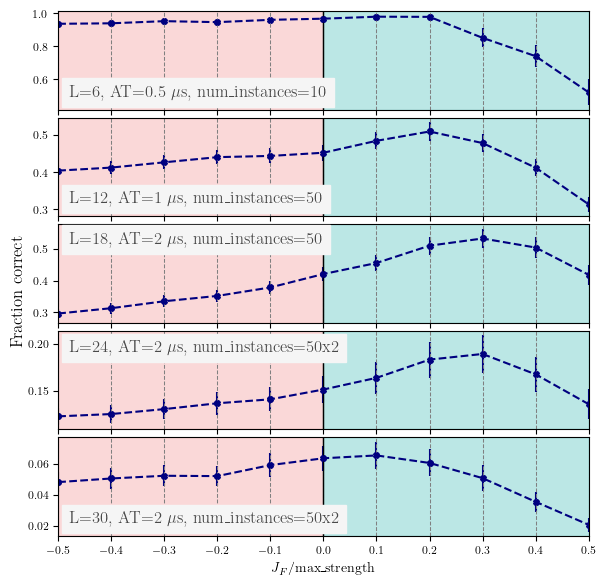

In [79]:
# there will be len(NTSs) many figures and each figure will be
# fraction correct vs gamma value
figure_size = get_figsize(latex_text_width_pt, text_height_pt=0.7*latex_text_height_pt, aspect_ratio=None)

figure, axs = plt.subplots( len(NTSs), 1, figsize=figure_size, sharex='col', sharey='row')

legend_set = False

if len(NTSs) == 1:
  axs = [axs]
  
for ax, NTS, NSS, AT, sds in zip(axs, NTSs,NSSs, ATs, seeds):

  ax.text(labels_x[(NTS,NSS)], labels_y[(NTS,NSS)], f"L={NTS}, AT={AT} $\mu$s, num_instances={num_instances[(NTS,NSS)]}",
          transform=ax.transAxes, 
          va='bottom', ha='left', backgroundcolor='whitesmoke',
          alpha=0.7, fontsize=12)

  if not legend_set:
    legend_set = True
    ax.errorbar(gamma_range, fraction_corrects['triangle'][(NTS,NSS)], 
                          xerr=None, yerr=stdevs['triangle'][(NTS,NSS)], 
                          marker=markers['EC_triangle'] , linestyle=linestyles['EC_triangle'],
                          color=colors['EC_triangle'], label=f"triangle")
    
    # # direct success rate
    # dsr = fraction_corrects['direct'][(NTS,NSS)][0]
    # # stdev
    # dsr_stdev = stdevs['direct'][(NTS,NSS)][0]

    # ax.axhline(y=dsr, color='blue', linewidth=2, label='direct')
    # ax.fill_between(gamma_range, dsr-dsr_stdev, dsr+dsr_stdev, color='blue', alpha=0.2)
    
  else:
    ax.errorbar(gamma_range, fraction_corrects['triangle'][(NTS,NSS)], 
                          xerr=None, yerr=stdevs['triangle'][(NTS,NSS)], 
                          marker=markers['EC_triangle'] , linestyle=linestyles['EC_triangle'],
                          color=colors['EC_triangle'])
    
    # # direct success rate
    # dsr = fraction_corrects['direct'][(NTS,NSS)][0]
    # # stdev
    # dsr_stdev = stdevs['direct'][(NTS,NSS)][0]

    # ax.axhline(y=dsr, color='blue', linewidth=2)
    # ax.fill_between(gamma_range, dsr-dsr_stdev, dsr+dsr_stdev, color='blue', alpha=0.2)

# set up the grid
for ax in axs:
  for gamma in gamma_range:
    ax.axvline(x=gamma, color='gray', linestyle='--', linewidth=0.75)

  ax.set_xticks(gamma_range)
  # let's also paint the background
  ax.axvspan(min(gamma_range), 0, color=antiferro_color, alpha=background_alpha)
  ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
  ax.axvspan(0, max(gamma_range), color=ferro_color, alpha=background_alpha)
  #ax.set_xlim(min(gamma_range), max(gamma_range))

ax.set_xlim(-0.5,0.5)
ax.set_xlabel("$J_F$/max\_strength")

figure.supylabel("Fraction correct")
#figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.08, top=0.98, wspace=0.05, hspace=0.08)

In [80]:
#figure.savefig("./figures_to_thesis/EC_gamma-sampling.pdf", format='pdf', dpi=300)

## Fraction correct vs problem size at optimal gamma

In [44]:
with open("/Users/beratyenilen/Desktop/Thesis/CODE/scripts/FM_ExactCover.pickle", "rb") as f:
  fitness_manager = pickle.load(f)

NTSs = [6,12,18,24,30]  # number of total sets
NSSs = [2,2,3,4,5]      # number of solution sets
ATs = [0.5, 1, 2, 2, 2] 
seeds = [range(1,11), range(1,51), range(1,51), range(1,100), [i for i in range(1,100) if i not in [15,50,65]]]
problem_types = ['direct', 'triangle']
main_dir = "/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/Exact_Cover"
sampler_id = 'Advantage_system5.4'
eu, na = 'eu-central-1', 'na-west-1'
gamma_range = np.linspace(-0.5, 0.5, 11)

In [45]:
#  [problem_type][(NTS,NSS)] -> fraction correct
fraction_corrects = {}
stdevs = {}

for problem_type in problem_types:
  fraction_corrects[problem_type], stdevs[problem_type] = {}, {}
  for NTS, NSS, AT, sds in zip(NTSs, NSSs, ATs, seeds):  
    # these will be dictionaries indexed by precision
    fraction_corrects[problem_type][(NTS,NSS)], stdevs[problem_type][(NTS,NSS)] = fitness_manager.get_fraction_correct(problem_type=problem_type,
                                                                                                                       NTS=NTS, NSS=NSS, 
                                                                                                                       seeds=sds, 
                                                                                                                       sampler_id=sampler_id, AT=AT,
                                                                                                                       return_stdev=True)

In [46]:
# let's calculate the optimal gamma values
# [error_model][L][precision] -> optimal gamma value 
optimal_gammas = {}
for NTS, NSS, AT, sds in zip(NTSs, NSSs, ATs, seeds):
  optimal_gamma_index = np.argmax(fraction_corrects['triangle'][(NTS,NSS)])
  optimal_gammas[(NTS,NSS)] = gamma_range[optimal_gamma_index]

In [47]:
# let's filter the fraction correct at optimal gamma values
# [(NTS,NSS)] -> fraction correct at optimal gamma value
fraction_corrects_at_optimal_gammas = {}
stdevs_at_optimal_gammas = {}
# similarly for 0 gamma
fraction_corrects_at_0_gammas = {}
stdevs_at_zero_gammas = {}
gamma_0_index = list(gamma_range).index(0)
for NTS,NSS in zip(NTSs, NSSs):
    optimal_gamma_index = np.argmax(fraction_corrects['triangle'][(NTS,NSS)])
    fraction_corrects_at_optimal_gammas[(NTS,NSS)] = fraction_corrects['triangle'][(NTS,NSS)][optimal_gamma_index]
    stdevs_at_optimal_gammas[(NTS,NSS)] = stdevs['triangle'][(NTS,NSS)][optimal_gamma_index]

    fraction_corrects_at_0_gammas[(NTS,NSS)] = fraction_corrects['triangle'][(NTS,NSS)][gamma_0_index]
    stdevs_at_zero_gammas[(NTS,NSS)] = stdevs['triangle'][(NTS,NSS)][gamma_0_index]

In [48]:

# For simplicity, defining a function to draw horizontal lines to nearest data points
def draw_horizontal_lines_to_nearest_data_points(ax, yticks, datasets, colors):
    # datasets is a list of tuples/lists: [(x_values, y_values, color), ...]
    for ytick in yticks:
        for data in datasets:
            x_values, y_values, color = data
            # Find indices where y-value is within 10^-3 of the ytick
            indices = [i for i, y in enumerate(y_values) if abs(ytick - y) < 10**(-3)]
            for i in indices:
                # Draw horizontal line from y-axis to the nearest x-value
                ax.hlines(y=ytick, xmin=0, xmax=x_values[i], colors='black', linestyles='--', alpha=0.7, linewidth=0.5)


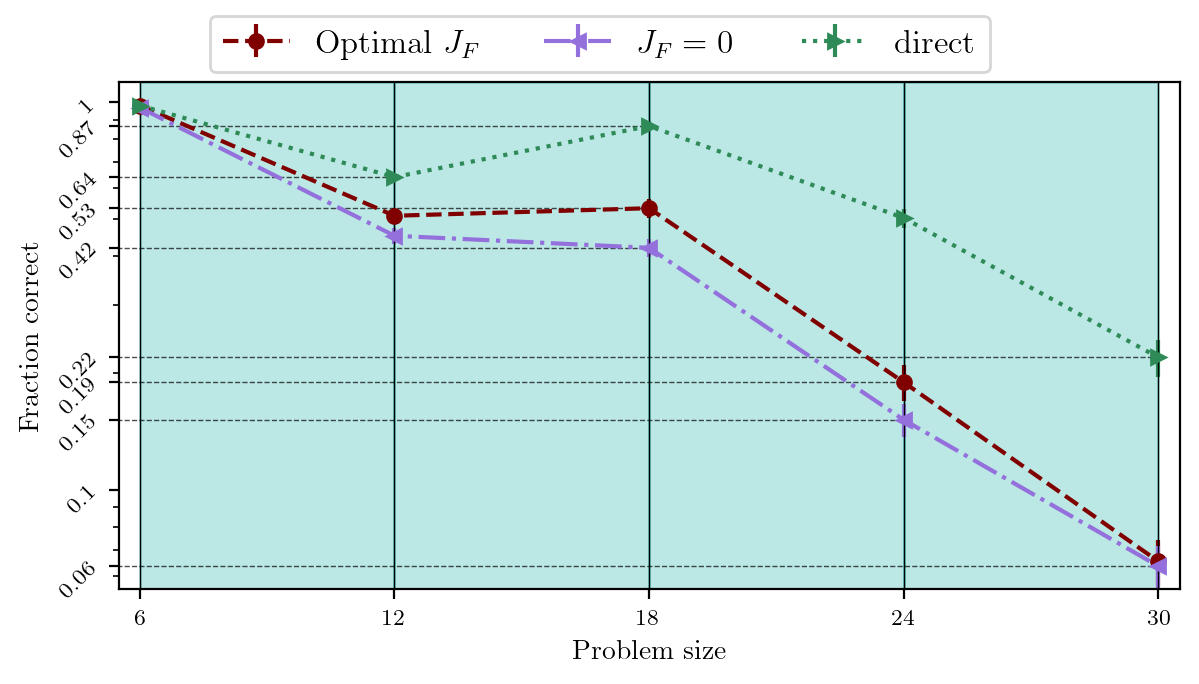

In [49]:
# run the 'Optimal Gamma Values' section cells to obtain the fraction correct and optimal gammas.
figure_size = get_figsize(latex_text_width_pt, text_height_pt=0.4*latex_text_height_pt, aspect_ratio=None)

# only one figure
figure, ax = plt.subplots(1, 1 , figsize=figure_size, sharex=True, sharey='row',dpi=200)

# set the yscale and the grid
ax.set_yscale('log')
markersize=5
# let's get the problem instance until which the optimal gamma is antiferromagnetic
L2gamma = {(NTS,NSS):optimal_gammas[(NTS,NSS)] for NTS,NSS in zip(NTSs, NSSs)}
for NTSl,NSSl in zip(NTSs, NSSs):
  for NTSr, NSSr in zip(NTSs, NSSs):
    if NTSl < NTSr:
      if L2gamma[(NTSl, NSSl)] < 0:
        ax.axvspan(NTSl, NTSr, color=antiferro_color, alpha=background_alpha)
      elif L2gamma[(NTSl, NSSl)] == 0 :
        ax.axvspan(NTSl, NTSr, color=gamma_zero_color, alpha=background_alpha)
      elif L2gamma[(NTSl, NSSl)] > 0:
        ax.axvspan(NTSl, NTSr, color=ferro_color, alpha=background_alpha)
      break

# Fraction corrects with optimal gammas
FC_OptG = [fraction_corrects_at_optimal_gammas[(NTS,NSS)] for NTS, NSS in zip(NTSs, NSSs)]
stdevs_OptG = [stdevs_at_optimal_gammas[(NTS,NSS)] for NTS,NSS in zip(NTSs,NSSs)]
# Fraction corrects with zero gamma
FC_0G = [fraction_corrects_at_0_gammas[(NTS,NSS)] for NTS, NSS in zip(NTSs, NSSs)]
stdevs_0G = [stdevs_at_zero_gammas[(NTS,NSS)] for NTS,NSS in zip(NTSs, NSSs)]
# direct fraction correct
FC_direct = [fraction_corrects['direct'][(NTS,NSS)][0] for NTS, NSS in zip(NTSs, NSSs)]
stdevs_direct = [ stdevs['direct'][(NTS,NSS)][0] for NTS, NSS in zip(NTSs, NSSs) ]

ax.errorbar(NTSs, FC_OptG, marker=markers['EC_optimal'], markersize=markersize,
            xerr=None, yerr=stdevs_OptG, color=colors['EC_optimal'], 
          linestyle=linestyles['EC_optimal'], label=f"Optimal $J_F$")

# Fraction correct  Small Instances 0 Gamma
ax.errorbar(NTSs, FC_0G, xerr=None, yerr=stdevs_0G, markersize=markersize,
            marker=markers['EC_zero'], color=colors['EC_zero'], 
            linestyle=linestyles['EC_zero'],label=f"$J_F =0$")
# fraction correct for minor embedded direct problems
ax.errorbar(NTSs, FC_direct, xerr=None, yerr=stdevs_direct, markersize=markersize,
            marker=markers['EC_direct'], color=colors['EC_direct'],
            linestyle=linestyles['EC_direct'],label='direct')

ax.set_xlim(5.5,30.5)
# we manually set the x ticks 
ax.set_xticks(NTSs)
for NTS in NTSs:
  ax.axvline(x=NTS, color='black', linewidth=0.5)

# lets set up the y ticks
yticks = [0.1, 1]
yticks += [FC_direct[1], FC_direct[2], FC_direct[-1]]
yticks += [FC_OptG[2], FC_OptG[3]]
yticks += [FC_0G[2], FC_0G[3], FC_0G[4]]

ax.set_yticks(yticks, labels=[round(y,2) for y in yticks])

# Define your datasets as a list of tuples [(x_values, y_values, color), ...]
datasets = [
    (NTSs, FC_OptG, colors['EC_optimal']),
    (NTSs, FC_0G, colors['EC_zero']),
    (NTSs, FC_direct, colors['EC_direct'])
]

# Assuming yticks is already defined and filtered to exclude 1 and 0.1
filtered_yticks = [ytick for ytick in yticks if ytick != 1 and ytick != 0.1]
draw_horizontal_lines_to_nearest_data_points(ax, filtered_yticks, datasets, colors)


plt.setp(ax.get_yticklabels(), rotation=45)

ax.set_xlabel("Problem size")
ax.set_ylabel("Fraction correct")
figure.legend(loc='upper center', ncols=3)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.12, top=0.88, wspace=0.05, hspace=0.06)

## Information Printing

In [50]:
print("Optimal gamma values")
for NTS, NSS in zip(NTSs, NSSs):
  print(f"L={NTS} optimal JF={optimal_gammas[(NTS,NSS)]}")

Optimal gamma values
L=6 optimal JF=0.10000000000000009
L=12 optimal JF=0.20000000000000007
L=18 optimal JF=0.30000000000000004
L=24 optimal JF=0.30000000000000004
L=30 optimal JF=0.10000000000000009


In [52]:
print(f"Differences in fraction correct at optimal JF, JF=0, and direct cases.")

for i, NTS, NSS in zip(range(len(NTSs)), NTSs, NSSs):
  fc_optimal = FC_OptG[i]
  std_optimal = stdevs_OptG[i]

  fc_0 = FC_0G[i]
  std_0 = stdevs_0G[i]

  fc_direct = FC_direct[i]
  std_direct = stdevs_direct[i]

      # improvement = ((fc_optimal - fc_0) / fc_0) * 100
      # stdev_improvement = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)

  opt_0_diff = ((fc_optimal - fc_0) / fc_0) * 100
  opt_0_diff_std = np.sqrt(((100 / fc_0) * std_optimal) ** 2 + ((-100 * fc_optimal / (fc_0 ** 2)) * std_0) ** 2)

  opt_dir_diff = (fc_direct - fc_optimal ) / fc_optimal * 100
  opt_dir_diff_std = np.sqrt(((100 / fc_optimal) * std_direct) ** 2 + ((-100 * fc_direct / (fc_optimal ** 2)) * std_optimal) ** 2)

  dir_0_diff = (fc_direct - fc_0 ) / fc_0 * 100
  dir_0_diff_std = np.sqrt(((100 / fc_0) * std_direct) ** 2 + ((-100 * fc_direct / (fc_0** 2)) * std_0) ** 2)

  print(f"NTS,NSS={NTS}, {NSS}")
  print(f"\toptimal JF = {fc_optimal} +- {std_optimal}  ; JF0= {fc_0} +- {std_0}   ; direct = {fc_direct} +- {std_direct}")
  print(f"\toptimal-zero percentage difference= {opt_0_diff} +- {opt_0_diff_std}%   , direct-optimal percentage difference={opt_dir_diff} +- {opt_dir_diff_std} ; direct-0 diff={dir_0_diff} +- {dir_0_diff_std}")

Differences in fraction correct at optimal JF, JF=0, and direct cases.
NTS,NSS=6, 2
	optimal JF = 0.978 +- 0.0044221663871405375  ; JF0= 0.966 +- 0.008055363982396379   ; direct = 0.978 +- 0.006798692684790377
	optimal-zero percentage difference= 1.2422360248447217 +- 0.9603735871619996%   , direct-optimal percentage difference=0.0 +- 0.8292791452349311 ; direct-0 diff=1.2422360248447217 +- 1.0991296596231144
NTS,NSS=12, 2
	optimal JF = 0.50837308 +- 0.02517417154731704  ; JF0= 0.45146196000000005 +- 0.021502700904351718   ; direct = 0.63942376 +- 0.016886833481753086
	optimal-zero percentage difference= 12.605961308456637 +- 7.7368292339934275%   , direct-optimal percentage difference=25.778446018424102 +- 7.058848967504342 ; direct-0 diff=41.63402825788466 +- 7.713510691055531
NTS,NSS=18, 3
	optimal JF = 0.53168 +- 0.03069768907077069  ; JF0= 0.42030999999999996 +- 0.02332853595483262   ; direct = 0.8660599999999999 +- 0.024950651866663294
	optimal-zero percentage difference= 26.4971

In [ ]:
#figure.savefig("./figures_to_thesis/EC_fraction_correct_optimal_gamma.pdf", format='pdf', dpi=300)

# END